### Dependências
___




In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install plotly
%pip install scipy
%pip install scikit-learn
%pip install statsmodels
%pip install pymrmr

### Imports
___

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import kstest, kruskal, norm
import statsmodels.api as sm
from plotly.subplots import make_subplots
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.naive_bayes import GaussianNB
import math
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import spearmanr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import pymrmr 

### Importar conjunto de dados
___

- Funções relacionados à limpeza tratamento e visualização de features

    - Remoção de features binárias
    - Remoção de features categóricas
    - Separação entre features e variável alvo
    - Normalização dos dados

In [3]:

DATA_PATH = 'PhiUSIIL_Phishing_URL_Dataset.csv'

def load_data(data_path=DATA_PATH):
    data = pd.read_csv(data_path)
    
    print("\nInformações do Dataset:")
    display(data.info())
    
    print("\nPrimeiras linhas do Dataset:")
    display(data.head(10))
    
    print("\nEstatísticas do Dataset:")
    display(data.describe())
    
    print("\nValores nulos no Dataset:")
    display(data.isnull().sum())
    
    # Modificar a coluna label para target, para ser de fácil perceção 
    data.rename(columns={'label': 'target'}, inplace=True)
    
    # Remover colunas categóricas
    categorical_columns = data.select_dtypes(include=['object']).columns
    data.drop(categorical_columns, axis=1, inplace=True)
    
    # Remover variáveis binárias excepto o target (label)
    binary_columns = [col for col in data.columns if data[col].nunique() == 2 and col != 'target']
    data.drop(binary_columns, axis=1, inplace=True)
    
    #Vai apresentar o nome das colunas
    #display("Columns: " + ", ".join(list(map(str, data.columns))))
    
    return data

In [4]:
def separar_features_target(data):
    X = data.copy()
    X.drop('target', axis=1,inplace=True)
    y = data['target'].copy()
    
    return X,y

In [5]:
def normalizar_features(X): 
  
    scaler = StandardScaler() # É o mesmo que usar Z_score, pois a média é 0 e o desvio padrão é 1
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X

 - Análise dos dados

   - 1 - Legítimo | 0 - Phishing

___

Podemos excluir features com correlação muito alta, pois podem ser redundantes (acima de 90%)

In [6]:
def plot_class_distribution(data):
    # Distribuição das classes
    values = data['target'].value_counts()
    keys = ['Legítimo', 'Phishing']
    
    fig_pie = px.pie(names=keys, values=values, title='Class Distribution (%)')
    fig_bar = px.bar(x=keys, y=values, labels={'x': 'Class', 'y': 'Count'},
                     title="Class Distribution (Phishing vs. Legitimate)")
    
    fig_pie.show()
    fig_bar.show()
    
    print("\nPerc. of class 1 (Legítimo): " + str(data['target'].sum() / data.shape[0] * 100) + " %")
    
    # Matriz de correlação
    corr_matrix = data.corr()
    threshold = 0.9
    features_to_drop = set()

    # Identificar features altamente correlacionadas
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                features_to_drop.add(colname)
    
    # Remover as features identificadas
    data = data.drop(columns=features_to_drop)
    
    print(f"Removed features: {features_to_drop}")
    
    # Plotar a matriz de correlação após a remoção
    plt.figure(figsize=(40, 40))
    sns.heatmap(data.corr(), annot=True, cmap='mako', vmin=-1.0)
    plt.title("Correlation Matrix (After Removal)")
    plt.show()
    
    return data


 -  Boxplot das Features Numéricas por Classe

In [7]:
def boxplot_features(df, target):
    # Substituir os valores 0 e 1 por 'Phishing' e 'Legitimate'
    df[target] = df[target].replace({0: 'Phishing', 1: 'Legitimate'})
    
    num_features = df.drop(columns=[target]).select_dtypes(include=['number']).columns  # Apenas features numéricas
    num_cols = 5  
    num_rows = 12  

    plt.figure(figsize=(num_cols * 5, num_rows * 5))  

    for i, feature in enumerate(num_features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=target, y=feature, data=df, hue=target, palette="coolwarm", dodge=False, legend=False)
        plt.title(f"Boxplot of {feature}")
        plt.xlabel(target)
        plt.ylabel(feature)

    plt.tight_layout()
    plt.show()


 -  Execução das funções referidas anteriomente
 
    - Correspendente visualização dos prints e gráficos


Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  in

None


Primeiras linhas do Dataset:


FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   
5   23107.txt     https://www.globalreporting.org         30   
6   23034.txt          https://www.saffronart.com         25   
7  696732.txt          https://www.nerdscandy.com         25   
8  739255.txt      https://www.hyderabadonline.in         29   
9   14486.txt                 https://www.aap.org         18   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   
5     www.globalreporting.org            23           0  org   
6          www.saffronart.com            18           0  com   
7          www.nerdscandy.com            18           0  com   
8      www.hyderabadonline.in            22           0   in   
9                 www.aap.org            11           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2               100.0              0.866667           0.028555  ...    0   
3               100.0              1.000000           0.522907  ...    1   
4               100.0              1.000000           0.079963  ...    1   
5               100.0              1.000000           0.079963  ...    0   
6               100.0              1.000000           0.522907  ...    0   
7               100.0              1.000000           0.522907  ...    0   
8               100.0              1.000000           0.005084  ...    0   
9               100.0              1.000000           0.079963  ...    0   

   Crypto  HasCopyrightInfo  NoOfImage  NoOfCSS  NoOfJS  NoOfSelfRef  \
0       0                 1         34       20      28          119   
1       0                 1         50        9       8           39   
2       0                 1         10        2       7           42   
3       1                 1          3       27      15           22   
4       0                 1        244       15      34           72   
5       0                 1         35        1      11           86   
6       0                 1         32        4      14           44   
7       0                 1         24        2      22           36   
8       0                 1         71        4       9           40   
9       0                 1         10        1      12          173   

   NoOfEmptyRef  NoOfExternalRef  label  
0             0              124      1  
1             0              217      1  
2             2                5      1  
3             1               31      1  
4             1               85      1  
5             0               14      1  
6             2               17      1  
7             0               15      1  
8             1              317      1  
9             6               65      1  

[10 rows x 56 columns]


Estatísticas do Dataset:


URLLength   DomainLength     IsDomainIP  URLSimilarityIndex  \
count  235795.000000  235795.000000  235795.000000       235795.000000   
mean       34.573095      21.470396       0.002706           78.430778   
std        41.314153       9.150793       0.051946           28.976055   
min        13.000000       4.000000       0.000000            0.155574   
25%        23.000000      16.000000       0.000000           57.024793   
50%        27.000000      20.000000       0.000000          100.000000   
75%        34.000000      24.000000       0.000000          100.000000   
max      6097.000000     110.000000       1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb    URLCharProb      TLDLength  \
count         235795.000000      235795.000000  235795.000000  235795.000000   
mean               0.845508           0.260423       0.055747       2.764456   
std                0.216632           0.251628       0.010587       0.599739   
min                0.000000           0.000000       0.001083       2.000000   
25%                0.680000           0.005977       0.050747       2.000000   
50%                1.000000           0.079963       0.057970       3.000000   
75%                1.000000           0.522907       0.062875       3.000000   
max                1.000000           0.522907       0.090824      13.000000   

       NoOfSubDomain  HasObfuscation  ...            Pay         Crypto  \
count  235795.000000   235795.000000  ...  235795.000000  235795.000000   
mean        1.164758        0.002057  ...       0.237007       0.023474   
std         0.600969        0.045306  ...       0.425247       0.151403   
min         0.000000        0.000000  ...       0.000000       0.000000   
25%         1.000000        0.000000  ...       0.000000       0.000000   
50%         1.000000        0.000000  ...       0.000000       0.000000   
75%         1.000000        0.000000  ...       0.000000       0.000000   
max        10.000000        1.000000  ...       1.000000       1.000000   

       HasCopyrightInfo      NoOfImage        NoOfCSS         NoOfJS  \
count     235795.000000  235795.000000  235795.000000  235795.000000   
mean           0.486775      26.075689       6.333111      10.522305   
std            0.499826      79.411815      74.866296      22.312192   
min            0.000000       0.000000       0.000000       0.000000   
25%            0.000000       0.000000       0.000000       0.000000   
50%            0.000000       8.000000       2.000000       6.000000   
75%            1.000000      29.000000       8.000000      15.000000   
max            1.000000    8956.000000   35820.000000    6957.000000   

         NoOfSelfRef   NoOfEmptyRef  NoOfExternalRef          label  
count  235795.000000  235795.000000    235795.000000  235795.000000  
mean       65.071113       2.377629        49.262516       0.571895  
std       176.687539      17.641097       161.027430       0.494805  
min         0.000000       0.000000         0.000000       0.000000  
25%         0.000000       0.000000         1.000000       0.000000  
50%        12.000000       0.000000        10.000000       1.000000  
75%        88.000000       1.000000        57.000000       1.000000  
max     27397.000000    4887.000000     27516.000000       1.000000  

[8 rows x 51 columns]


Valores nulos no Dataset:


FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore         0
URLTitle


Perc. of class 1 (Legítimo): 57.189507835195826 %
Removed features: {'URLTitleMatchScore', 'NoOfLettersInURL'}


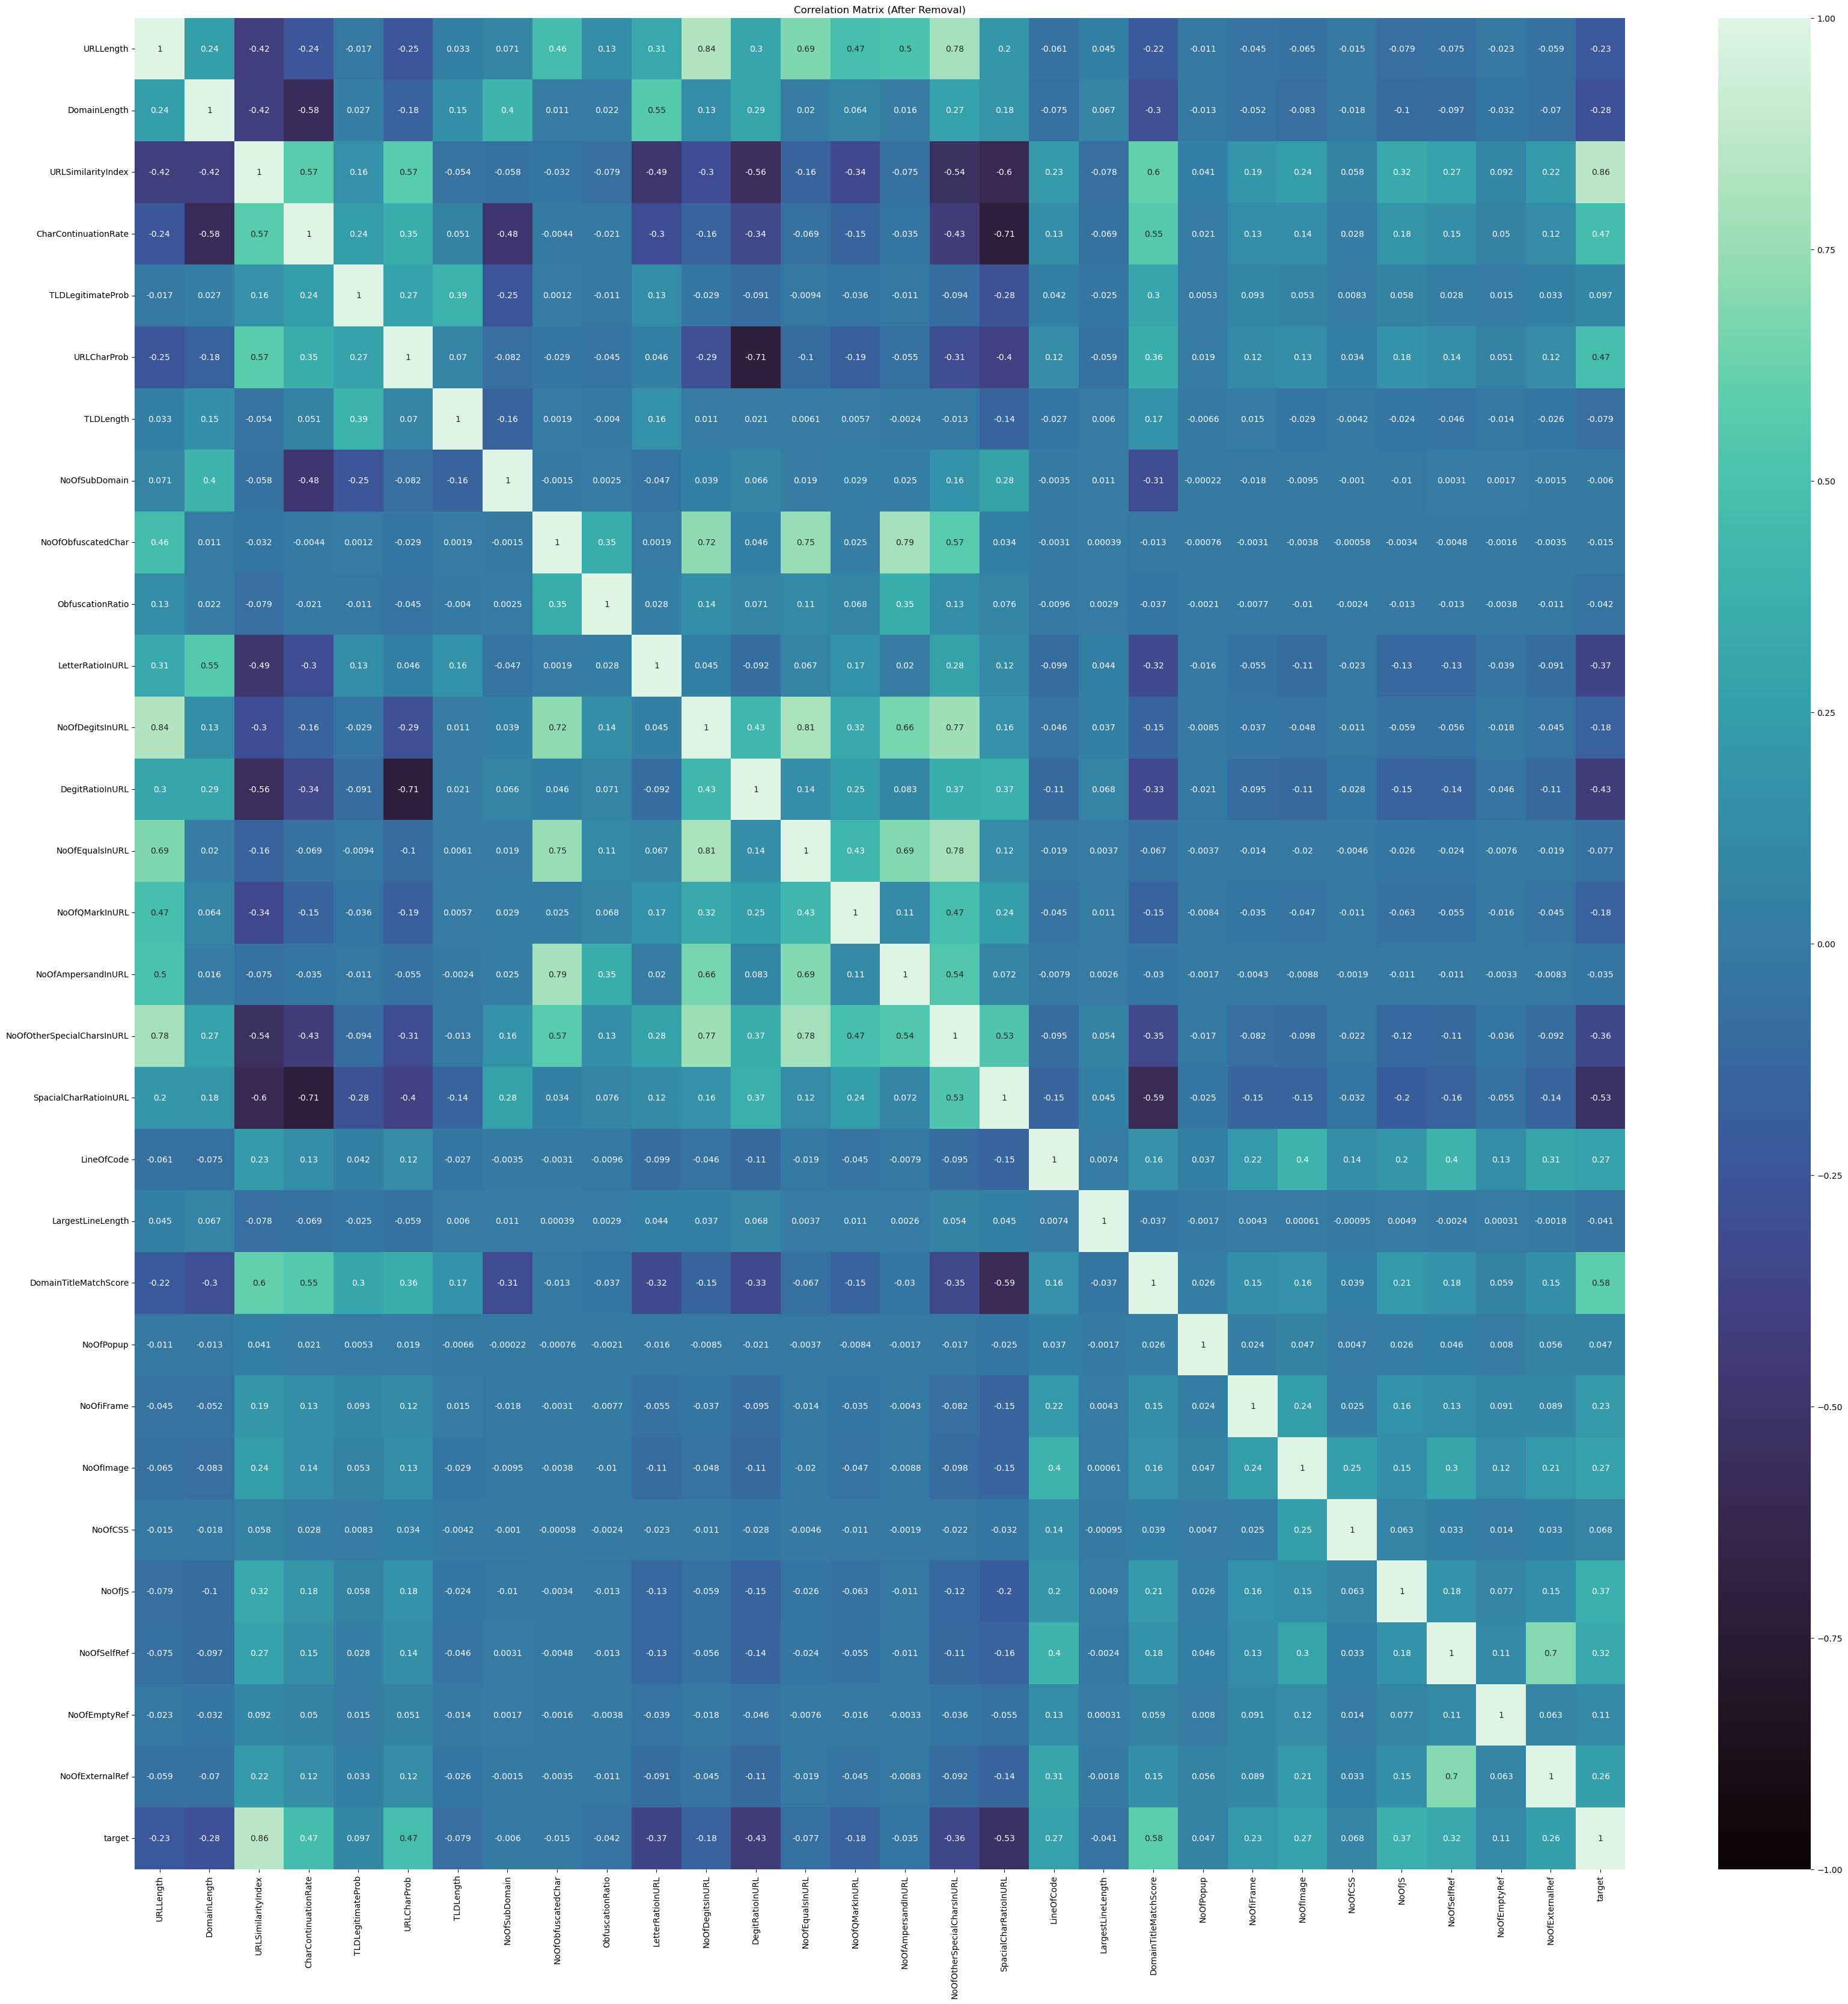

In [8]:

data = load_data()

data = plot_class_distribution(data)
X, y = separar_features_target(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = normalizar_features(X_train)
X_test = normalizar_features(X_test)


# Resetar os índices para evitar desalinhamento
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_original = deepcopy(X_train)
X_test_original = deepcopy(X_test)
y_train_original = deepcopy(y_train)
y_test_original = deepcopy(y_test)


### Kolmogorov-Smirnov Test

___

 -  Primeiro, usamos KS-Test no dataset completo para averiguar se as features seguem uma distribuição normal

 -  Depois, usamos KS-Test separado por target para verificar se as distribuições variam entre phishing e legítimo

 - Se houver uma diferença grande entre classes, a feature pode ser relevante para classificação


In [9]:

def KS_Test(X, y, features, alpha=0.05):
    
    # Separar por target e verificar se segue uma distribuição normal
    normal_features_target = {}
    non_normal_features_target = {}
    for f in features:
        for cls in [0, 1]:  # 1 = Legítimo, 0 = Phishing
            class_data = X[y == cls][f]
            class_data = (class_data - class_data.mean()) / class_data.std()  # Normalização Z-score
            
            ks_stat, p_value = kstest(class_data, 'norm')
            #print(f"Feature: {f}, Classe: {cls}, KS Statistic: {ks_stat}, p-value: {p_value}")
            if p_value > alpha:
                normal_features_target[f] = cls
            else:
                non_normal_features_target[f] = cls
                     
    # Sem separar por target
    ks_statistic = []
    p_value = []
    
    normal_features = []
    non_normal_features = []
    i = 0
    
    for feature in features:
        featV = X[feature]
        
        if i == 10:  # Plotar apenas para a primeira feature (ou ajuste o valor de `i` para outra feature)
            fig = make_subplots(rows=1, cols=2, subplot_titles=("CDF vs ECDF", "PDF vs EPDF"))

            # Adicionar histograma/EPDF
            fig.add_trace(go.Histogram(x=featV, nbinsx=20, histnorm='probability density', name="EPDF"), row=1, col=2)

            # Gerar dados para a distribuição normal
            mu = 0  # Média
            sigma = 1  # Desvio padrão
            x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)  # Expandir intervalo para cobrir 3 desvios padrão
            pdf = norm.pdf(x, mu, sigma)
            cdf = norm.cdf(x, mu, sigma)

            # Adicionar PDF ao histograma
            fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines', name="PDF"), row=1, col=2)

            # Plotar CDF teórica e empírica
            ecdf = sm.distributions.ECDF(featV)
            xs = np.linspace(min(featV), max(featV))
            ecdfs = ecdf(xs)
            fig.add_trace(go.Scatter(x=xs, y=ecdfs, mode='lines', name="ECDF"), row=1, col=1)
            fig.add_trace(go.Scatter(x=x, y=cdf, mode='lines', name="CDF"), row=1, col=1)

            # Atualizar propriedades do eixo x para centralizar o histograma
            feat_min = min(featV)
            feat_max = max(featV)
            feat_range = max(abs(feat_min), abs(feat_max))
            fig.update_xaxes(title_text=feature, row=1, col=1, range=[-feat_range, feat_range])
            fig.update_xaxes(title_text=feature, row=1, col=2, range=[-feat_range, feat_range])  # Centralizar o histograma
            fig.update_yaxes(title_text="CDF/ECDF", row=1, col=1)
            fig.update_yaxes(title_text="PDF/EPDF", row=1, col=2)
            fig.update_layout(autosize=False, width=1600, height=800, font=dict(size=18, color="black"))

            fig.show()
            
        i += 1
        
        ks, pvalue = kstest(featV, norm.cdf)
        ks_statistic.append(ks)
        p_value.append(pvalue)
        if pvalue > alpha:
            normal_features.append(feature)
        else:
            non_normal_features.append(feature)
                
    print(ks_statistic)
    print(p_value)
    
    return normal_features, non_normal_features
                
            
normal_features, non_normal_features = KS_Test(X_train, y_train, X_train.columns)
# Nenhuma feature segue uma distribuição normal (p-value < 0.05)
print("Features Normal Distribution : ", normal_features)
print("Features Non Normal Distribution: ", non_normal_features)

[0.3314417220568453, 0.14662299203777396, 0.34683374707233733, 0.35540629133602153, 0.3285415556716964, 0.10172910956509973, 0.3584025527081369, 0.42396538519119037, 0.5030810755142483, 0.5122861319492866, 0.032774326721400626, 0.4402666479158043, 0.438111525494296, 0.5021951713878242, 0.5343884595312343, 0.5077249946407448, 0.3574034156672424, 0.1804376359216795, 0.3731650725430147, 0.4666915943118157, 0.327802248272851, 0.4777429037889962, 0.3937725038108115, 0.36694052133591193, 0.4695506455109987, 0.32720338071276645, 0.33795360633515464, 0.44851606630360275, 0.3638738940721309]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.78744466590217e-176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Features Normal Distribution :  []
Features Non Normal Distribution:  ['URLLength', 'DomainLength', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'Obfuscation

### Kruskal Wallis Test
___

 - Visualização do plot do rank, para melhor escolha de features

In [10]:

def KW_test(X, y,features):
    Hs = {}
    
    ix_legitimo = np.where(y == 1)[0]
    ix_phishing = np.where(y == 0)[0]
   
    for i in range(X.shape[1]):
        stat = kruskal(X.iloc[ix_legitimo, i], X.iloc[ix_phishing, i]) # iloc trabalha com pandas, flatten trabalha com numpy
        Hs[features[i]] = stat  
 
    Hs_sorted = sorted(Hs.items(), key=lambda x: x[1], reverse=True)
    
    return Hs_sorted



Hs_sorted = KW_test(X_train,y_train, X_train.columns)
print(Hs_sorted)
    


[('URLSimilarityIndex', KruskalResult(statistic=168522.69784855554, pvalue=0.0)), ('NoOfImage', KruskalResult(statistic=134035.4166557541, pvalue=0.0)), ('NoOfExternalRef', KruskalResult(statistic=133861.57442839342, pvalue=0.0)), ('LineOfCode', KruskalResult(statistic=133419.1965442928, pvalue=0.0)), ('NoOfSelfRef', KruskalResult(statistic=129580.96985979662, pvalue=0.0)), ('NoOfJS', KruskalResult(statistic=127799.93855098792, pvalue=0.0)), ('NoOfCSS', KruskalResult(statistic=121639.5011149739, pvalue=0.0)), ('NoOfOtherSpecialCharsInURL', KruskalResult(statistic=70723.16619596982, pvalue=0.0)), ('DomainTitleMatchScore', KruskalResult(statistic=60857.53892476535, pvalue=0.0)), ('LargestLineLength', KruskalResult(statistic=55366.409807537006, pvalue=0.0)), ('NoOfDegitsInURL', KruskalResult(statistic=55180.38673920954, pvalue=0.0)), ('DegitRatioInURL', KruskalResult(statistic=54239.89820651114, pvalue=0.0)), ('SpacialCharRatioInURL', KruskalResult(statistic=52404.449408142435, pvalue=0.0


Ranking das Features com Base no Kruskal-Wallis:


Feature           Rank
0           URLSimilarityIndex  168522.697849
1                    NoOfImage  134035.416656
2              NoOfExternalRef  133861.574428
3                   LineOfCode  133419.196544
4                  NoOfSelfRef  129580.969860
5                       NoOfJS  127799.938551
6                      NoOfCSS  121639.501115
7   NoOfOtherSpecialCharsInURL   70723.166196
8        DomainTitleMatchScore   60857.538925
9            LargestLineLength   55366.409808
10             NoOfDegitsInURL   55180.386739
11             DegitRatioInURL   54239.898207
12       SpacialCharRatioInURL   52404.449408
13                  NoOfiFrame   51068.621106
14                NoOfEmptyRef   50116.909070
15        CharContinuationRate   41522.783866
16                 URLCharProb   39891.185569
17                   URLLength   30159.104216
18            LetterRatioInURL   25797.256249
19                DomainLength    8711.078522
20           TLDLegitimateProb    7304.001996
21                   NoOfPopup    7051.515094
22              NoOfQMarkInURL    6760.766830
23             NoOfEqualsInURL    5941.669764
24          NoOfAmpersandInURL     958.775972
25                   TLDLength     581.648333
26          NoOfObfuscatedChar     515.360726
27            ObfuscationRatio     515.360643
28               NoOfSubDomain     194.089861

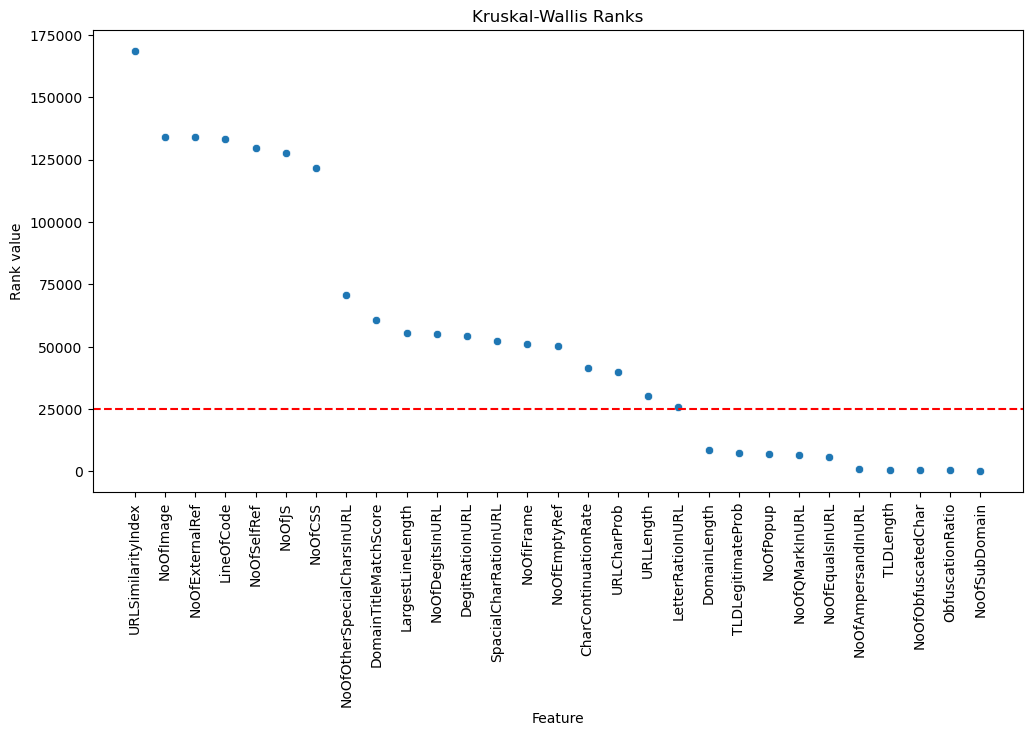

In [11]:
def plot_rank(rank):
    # Extrair os valores de rank (estatísticas de Kruskal-Wallis) e os nomes das features
    rank_values = [item[1].statistic for item in rank]
    feature_names = [item[0] for item in rank]
    
    rank_df = pd.DataFrame({'Feature': feature_names, 'Rank': rank_values})
    
    print("\nRanking das Features com Base no Kruskal-Wallis:")
    display(rank_df)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=rank_df, x='Feature', y='Rank')
    plt.axhline(y=25000, color='r', linestyle='--')
    
    plt.title("Kruskal-Wallis Ranks")
    plt.ylabel("Rank value")
    plt.xlabel("Feature")
    plt.xticks(rotation=90)  
    plt.show()
    
plot_rank(Hs_sorted)

    

-  Eliminação das features com rank abaixo de 25 000

In [12]:
cols = [x[0] for x in Hs_sorted if x[1].statistic > 25000]
X_train = X_train[cols]
X_test = X_test[cols]

### PCA

___


    

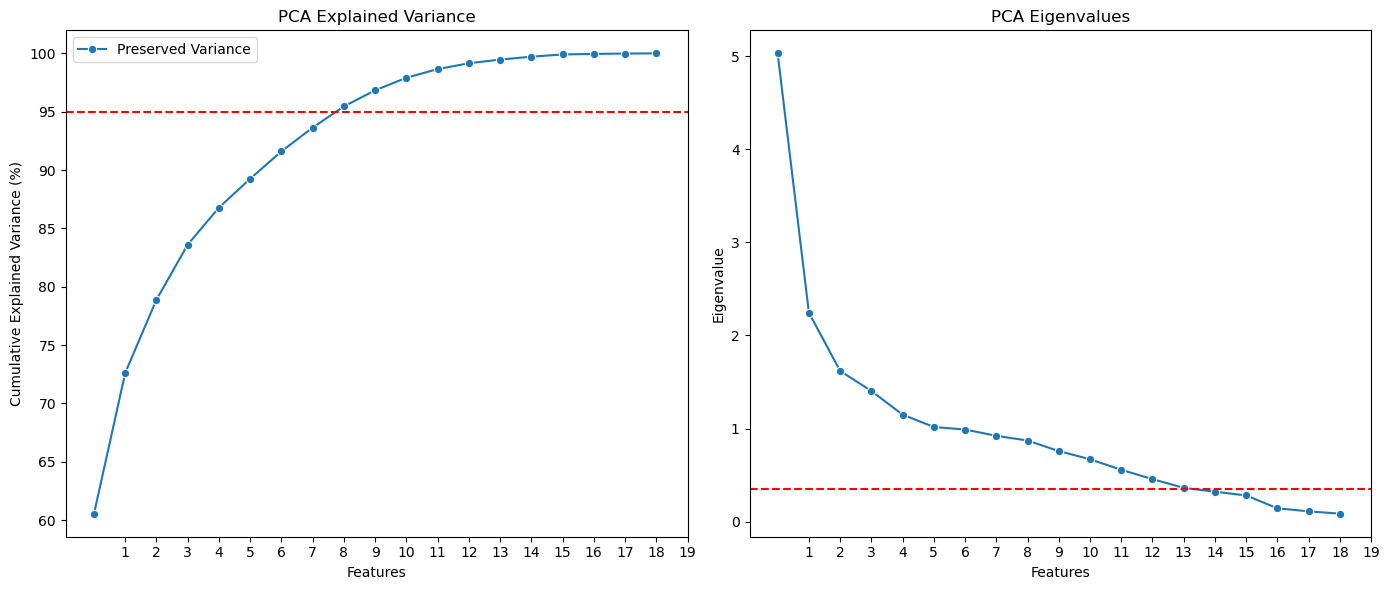

In [13]:
def pca_function(x):

    pca = PCA(n_components=x.shape[1])
    pca.fit(x)
    
    # Calcular a razão da variância explicada
    explained_variance_ratio = pca.explained_variance_ratio_
    #print(explained_variance_ratio)
    
    eigenvalues = pca.explained_variance_
    preserved_variance = [(eigenvalues[:i+1]**2).sum() / (eigenvalues**2).sum() * 100 for i in range(len(eigenvalues))]
    preserved_variance = pd.DataFrame(preserved_variance, columns=['Preserved Variance'])
    return pca, preserved_variance, eigenvalues

pca, preserved_variance, eigenvalues= pca_function(X_train)

def plots_pca(preserved_variance, eigenvalues):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.lineplot(ax=axes[0], data=preserved_variance, marker='o')
    axes[0].axhline(y=95, color='r', linestyle='--')
    axes[0].set_title("PCA Explained Variance")
    axes[0].set_xlabel("Features")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].set_xticks(range(1, len(preserved_variance) + 1))


    sns.lineplot(ax=axes[1], data=eigenvalues, marker='o')
    axes[1].set_title("PCA Eigenvalues")
    axes[1].set_xlabel("Features")
    axes[1].set_ylabel("Eigenvalue")
    axes[1].set_xticks(range(1, len(eigenvalues) + 1))
    plt.axhline(y=0.35, color='r', linestyle='--')
    

    plt.tight_layout()
    plt.show()
    
plots_pca(preserved_variance, eigenvalues)


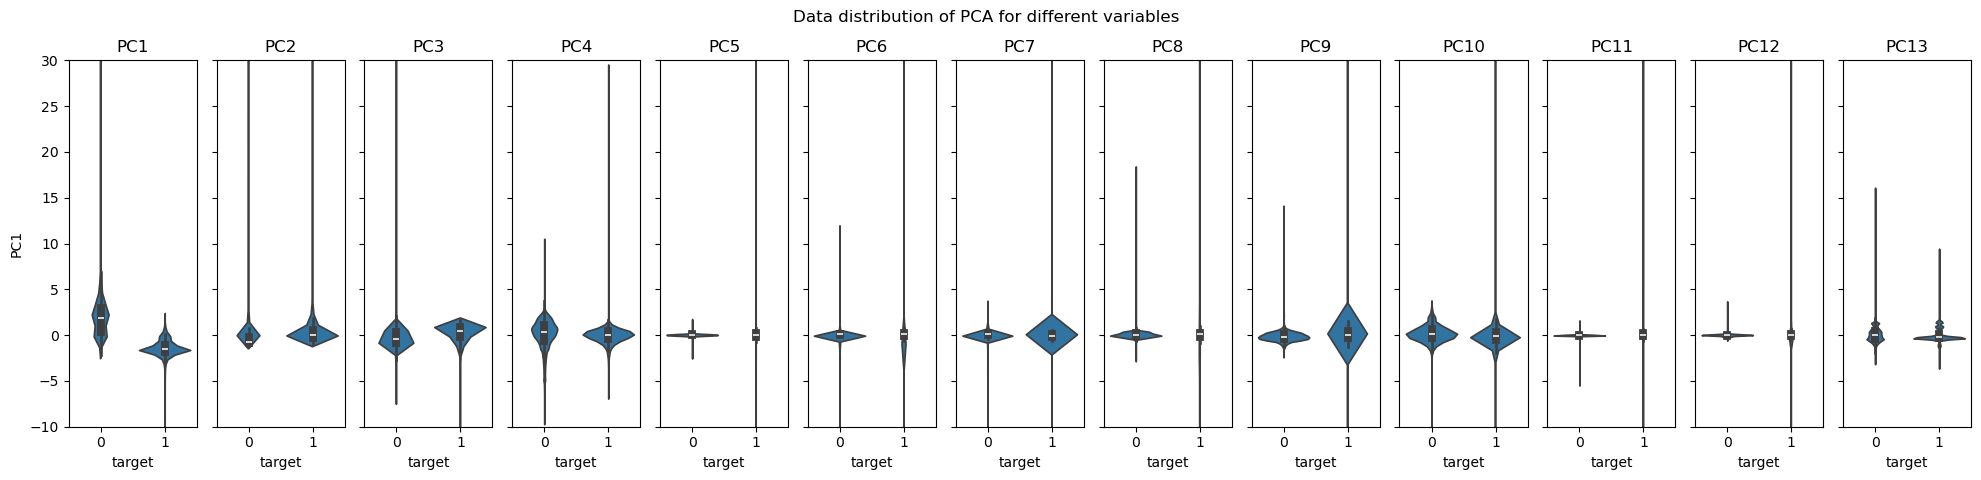

In [14]:
def plot_pca_distribution(X, y, X_test, n_components=13):

    pca = PCA(n_components=n_components)
    x_pca = pd.DataFrame(pca.fit_transform(X), columns=[f'PC{i+1}' for i in range(n_components)])
    X_test_pca = pd.DataFrame(pca.transform(X_test), columns=[f'PC{i+1}' for i in range(n_components)])

    # Combinar o PCA com o target
    df = x_pca.copy()
    df['target'] = y


    fig, axes = plt.subplots(1, n_components, figsize=(20, 5), sharey=True)
    for i, feature in enumerate(x_pca.columns):
        sns.violinplot(data=df, x='target', y=feature, ax=axes[i])
        axes[i].set_title(f"PC{i+1}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.ylim(-10, 30)
    plt.suptitle("Data distribution of PCA for different variables")
    plt.show()
    return x_pca, X_test_pca


x_pca,X_test_pca = plot_pca_distribution(X_train, y_train, X_test)

### LDA

___

In [15]:
def lda(X, y, X_test):
      
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    X_lda = pd.DataFrame(lda.transform(X), columns=['Feature'])
    X_test_lda = pd.DataFrame(lda.transform(X_test), columns=['Feature'])
    
    return X_lda, X_test_lda

x_lda, X_test_lda = lda(X_train, y_train, X_test)


In [16]:
def plot_lda(X_lda, y):
    
    df = pd.DataFrame(data=X_lda, columns=['Feature'])  
    df["Class"] = y  
    
    plt.figure()
    sns.kdeplot(data=df[df['Class'] == 0]['Feature'], label="Phishing", fill=True, color='red')
    sns.kdeplot(data=df[df['Class'] == 1]['Feature'], label="Legítimo", fill=True, color='blue')
    plt.legend()
    plt.title("Distribution of LDA Projection by Class")
    plt.xlabel("LDA Feature")
    plt.ylabel("Density")
    plt.show()
    
    

### ROC

___

 - Aplicar o ROC para a seleção de features

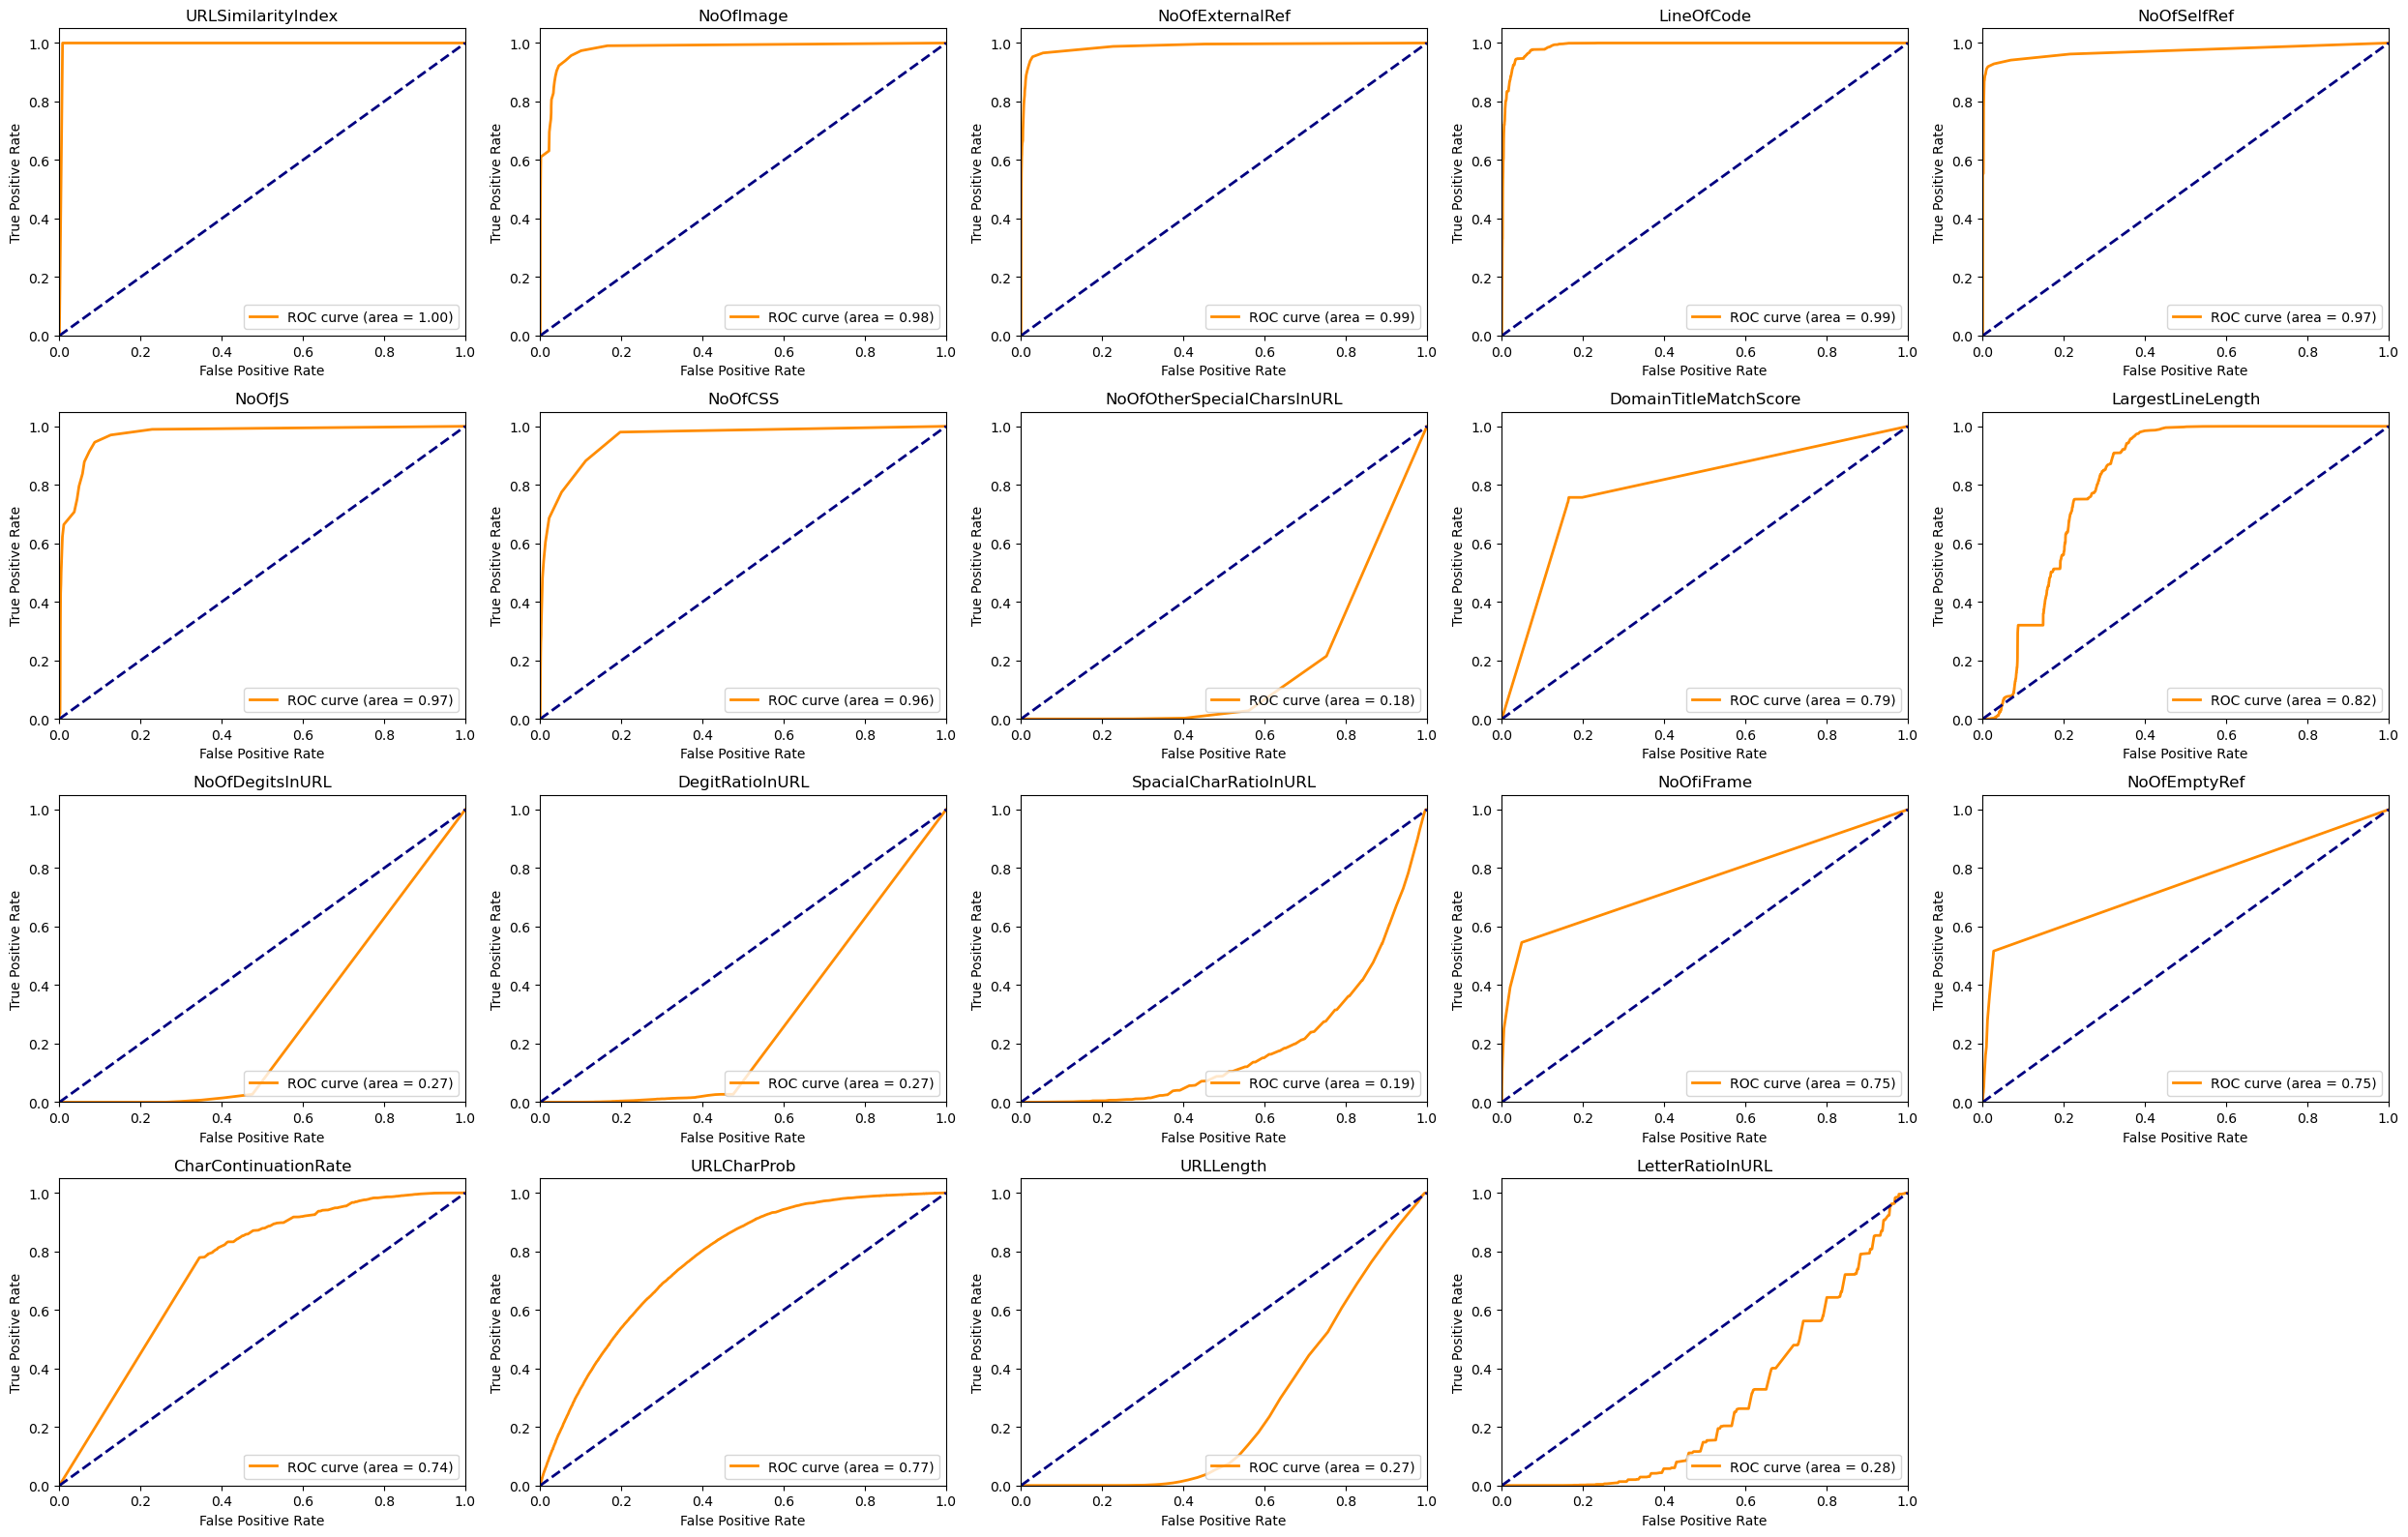

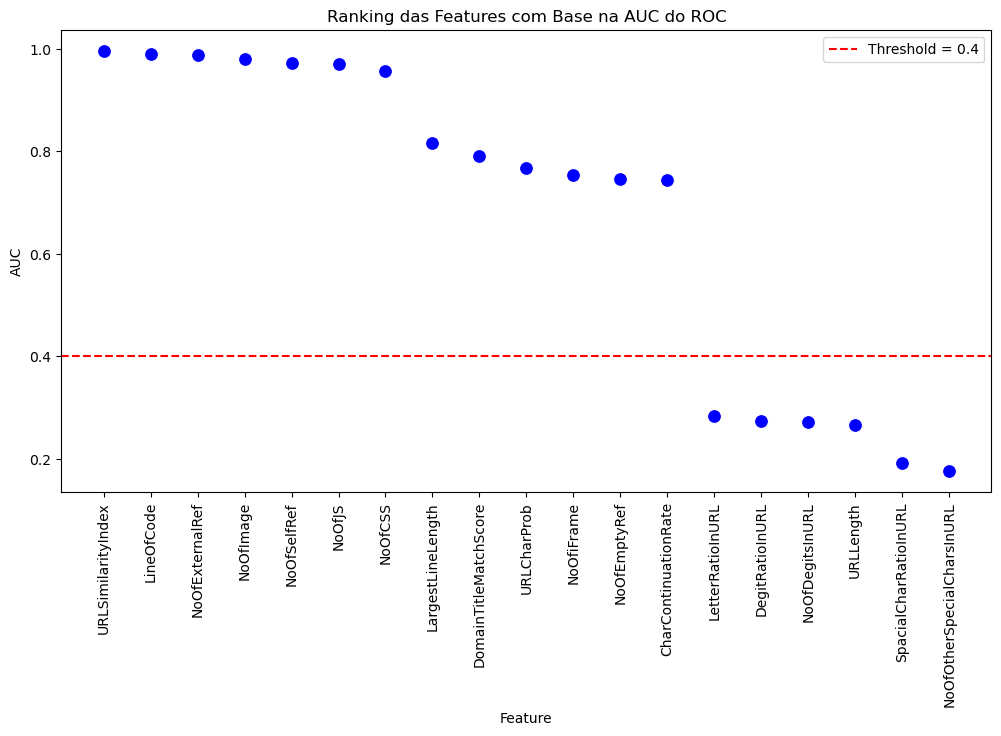


Ranking das Features com Base na AUC:


AUC
URLSimilarityIndex          0.996217
LineOfCode                  0.990279
NoOfExternalRef             0.987903
NoOfImage                   0.979903
NoOfSelfRef                 0.972245
NoOfJS                      0.970881
NoOfCSS                     0.957402
LargestLineLength           0.816051
DomainTitleMatchScore       0.791437
URLCharProb                 0.768289
NoOfiFrame                  0.754290
NoOfEmptyRef                0.745444
CharContinuationRate        0.743512
LetterRatioInURL            0.284322
DegitRatioInURL             0.273647
NoOfDegitsInURL             0.271716
URLLength                   0.266954
SpacialCharRatioInURL       0.192625
NoOfOtherSpecialCharsInURL  0.176237

In [17]:
def plot_roc_features(X, y):
   
    n_features = X.shape[1]
    n_cols = 5
    n_rows = math.ceil(n_features / n_cols)  # Calcula o número de linhas necessário

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()  # Achatar os eixos para facilitar a iteração

    auc_scores = {}

    for i, feature in enumerate(X.columns):
        fpr, tpr, thresholds = roc_curve(y, X[feature])
        roc_auc = auc(fpr, tpr)
        auc_scores[feature] = roc_auc
        
        axes[i].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend(loc='lower right')
        axes[i].set_title(f'{feature}')

    # Remover subplots vazios (se houver)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
    auc_df = pd.DataFrame.from_dict(auc_scores, orient='index', columns=['AUC'])
    auc_df = auc_df.sort_values(by='AUC', ascending=False)
    
    return auc_df

def plot_roc_rank(auc_df, threshold=0.4):
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=auc_df, x=auc_df.index, y='AUC', color='blue', s=100)
    
    # Adicionar uma linha de limite para a AUC
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
    
    plt.title("Ranking das Features com Base na AUC do ROC")
    plt.ylabel("AUC")
    plt.xlabel("Feature")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


auc_df = plot_roc_features(X_train, y_train)

plot_roc_rank(auc_df)

print("\nRanking das Features com Base na AUC:")
display(auc_df)

###  Minimum Redundancy Maximum Relevance (mRMR)

____

In [18]:
def mRMR(X, y, k=None):
 
    if k is None:
        k = X.shape[1]
    
    
    # Calcular informação mútua para uso posterior no dicionário de importance_scores
    mi_scores = mutual_info_classif(X, y, random_state=42)
    mi_dict = {feature: score for feature, score in zip(X.columns, mi_scores)}
    
    selected_features = pymrmr.mRMR(X, 'MIQ', k)
    
    # Criar dicionário de importance_scores
    # Como pymrmr não retorna scores diretamente,
    # usamos informação mútua como aproximação
    importance_scores = {feature: mi_dict.get(feature, 0) for feature in selected_features}
    
    return selected_features, importance_scores


selected_features, importance_scores = mRMR(X_train, y_train)
print("\nSelected Features with mRMR: ", selected_features)



Selected Features with mRMR:  ['URLLength', 'SpacialCharRatioInURL', 'LetterRatioInURL', 'NoOfExternalRef', 'NoOfDegitsInURL', 'DomainTitleMatchScore', 'LargestLineLength', 'URLCharProb', 'NoOfOtherSpecialCharsInURL', 'NoOfJS', 'CharContinuationRate', 'NoOfiFrame', 'DegitRatioInURL', 'NoOfImage', 'NoOfEmptyRef', 'LineOfCode', 'NoOfSelfRef', 'NoOfCSS', 'URLSimilarityIndex']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


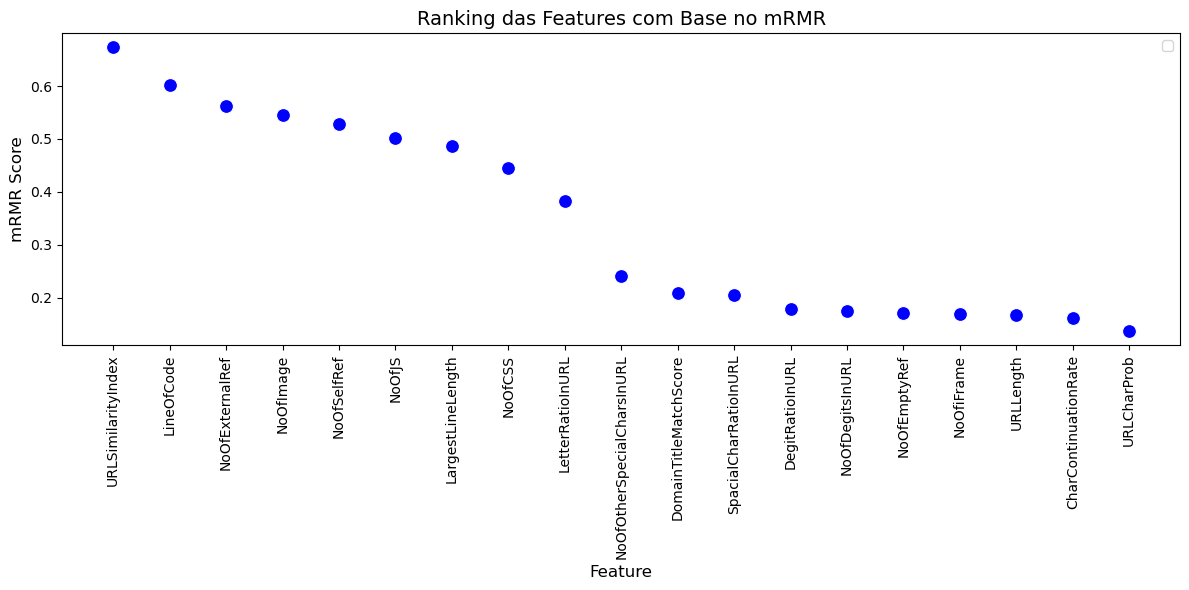

In [20]:
def plot_mrmr_rank(scores_df, threshold=0.0):
    
    plt.figure(figsize=(12, 6))
    
    scores_df = pd.DataFrame({
    'Feature': list(importance_scores.keys()),
    'mRMR Score': list(importance_scores.values())
    }).sort_values(by='mRMR Score', ascending=False)
    

    sns.scatterplot(
        data=scores_df, 
        x='Feature', 
        y='mRMR Score', 
        color='blue', 
        s=100
    )
    
    #plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')

    plt.title("Ranking das Features com Base no mRMR", fontsize=14)
    plt.ylabel("mRMR Score", fontsize=12)
    plt.xlabel("Feature", fontsize=12)
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_mrmr_rank(importance_scores)
    

 - Comparação entre diversos métodos de feature selection 
   - KW
   - ROC
   - mRMR

Conclusão: Podemos continuar a utilizar as features escolhidas pelo KW, uma vez que os diversos ranks mostram praticamente as mesmas com a excesão de uma ou duas 

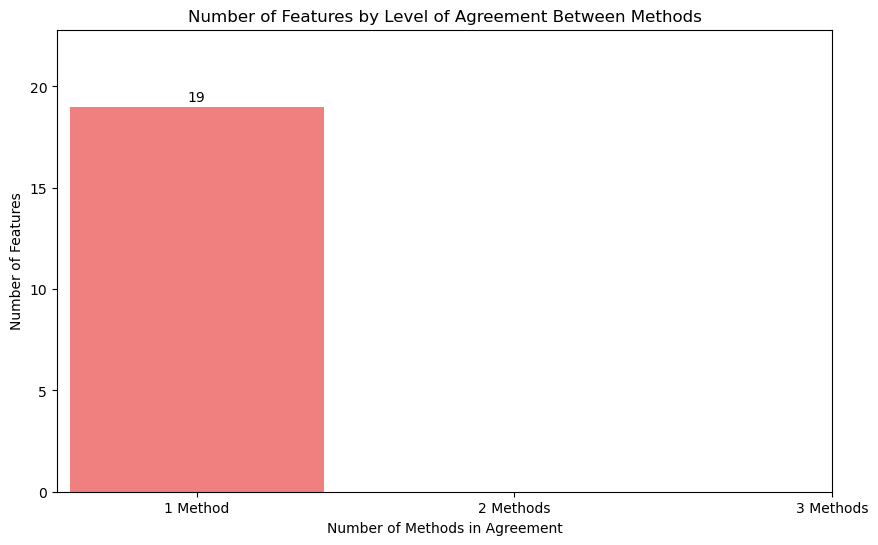


Final Features Selected:  ['CharContinuationRate', 'SpacialCharRatioInURL', 'LargestLineLength', 'URLSimilarityIndex', 'LetterRatioInURL', 'LineOfCode', 'NoOfImage', 'NoOfExternalRef', 'URLCharProb', 'DegitRatioInURL', 'DomainTitleMatchScore', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfOtherSpecialCharsInURL', 'NoOfJS', 'NoOfDegitsInURL', 'NoOfCSS', 'NoOfiFrame', 'URLLength']


In [21]:
def compare_rankings(mrmr_df, kruskal_ranks, roc_ranks, top_n=19):

    mrmr_top = mrmr_df.head(top_n).reset_index(drop=True)
    
    kruskal_features = [item[0] for item in kruskal_ranks[:top_n]]
    kruskal_values = [item[1].statistic for item in kruskal_ranks[:top_n]]
    kruskal_top = pd.DataFrame({
        'Feature_Kruskal': kruskal_features,
        'Score_Kruskal': kruskal_values
    })
    
    roc_top = roc_ranks.head(top_n).reset_index()
    roc_top.columns = ['Feature_ROC', 'Score_ROC']
    
    comparison = pd.DataFrame({
        'mRMR Rank': mrmr_top['Feature'],
        'Kruskal-Wallis Rank': kruskal_top['Feature_Kruskal'],
        'ROC AUC Rank': roc_top['Feature_ROC']
    })
    
    all_features = set(mrmr_top['Feature']).union(set(kruskal_top['Feature_Kruskal'])).union(set(roc_top['Feature_ROC']))
    
    # Count how many methods each feature appears in
    feature_counts = {}
    for feature in all_features:
        count = 0
        if feature in mrmr_top['Feature'].values:
            count += 1
        if feature in kruskal_top['Feature_Kruskal'].values:
            count += 1
        if feature in roc_top['Feature_ROC'].values:
            count += 1
        feature_counts[feature] = count
    
    feature_agreement = pd.DataFrame({
        'Feature': list(feature_counts.keys()),
        'Methods_Agreement': list(feature_counts.values())
    }).sort_values(by='Methods_Agreement', ascending=False)
    
    return comparison, feature_agreement

def select_final_features(X, comparison_df, feature_agreement_df, min_agreement=2):
   
    # Select features that appear in at least min_agreement methods
    final_features = feature_agreement_df[feature_agreement_df['Methods_Agreement'] >= min_agreement]['Feature'].tolist()
    
    # Verify if the selected features exist in the original DataFrame
    final_features = [f for f in final_features if f in X.columns]
    
    return final_features

def visualize_feature_agreement(feature_agreement_df):
   
    # Count how many features have each level of agreement
    agreement_counts = feature_agreement_df['Methods_Agreement'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        agreement_counts.index.astype(str), 
        agreement_counts.values, 
        color=['lightcoral', 'yellowgreen', 'steelblue']
    )
    
    # Add labels to the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.1, 
            f'{int(height)}', 
            ha='center', va='bottom'
        )
    
    plt.title('Number of Features by Level of Agreement Between Methods')
    plt.xlabel('Number of Methods in Agreement')
    plt.ylabel('Number of Features')
    plt.ylim(0, max(agreement_counts.values) * 1.2)  # Adjust y-axis limit
    plt.xticks([0, 1, 2], ['1 Method', '2 Methods', '3 Methods'])
    plt.show()
    
comparison_df, feature_agreement_df = compare_rankings(
    mrmr_df=pd.DataFrame({'Feature': selected_features, 'mRMR Score': list(importance_scores.values())}),
    kruskal_ranks=Hs_sorted,
    roc_ranks=auc_df
)
visualize_feature_agreement(feature_agreement_df)
final_features = select_final_features(X_train, comparison_df, feature_agreement_df, min_agreement=2)
print("\nFinal Features Selected: ", final_features)

### MDC

___

 - Métrica Euclidiana
 - Métrica Mahalanobis

In [ ]:
class MinimumDistanceClassifier:
    def __init__(self, metric="euclidean"):
        self.metric = metric
        self.centroids = {}
        self.variances = {}  # Para 1D na Mahalanobis
        self.covariances = {}  # Para Multidimensional na Mahalanobis

    def fit(self, X_train, y_train):
        classes = np.unique(y_train)
        
        # Calcula a média (centroide) de cada classe
        self.centroids = {c: X_train[y_train == c].mean().values for c in classes}

        if self.metric == "mahalanobis":
            if X_train.shape[1] == 1:  # Caso unidimensional
                self.variances = {c: X_train[y_train == c].var().iloc[0] for c in classes}
            else:  # Caso multidimensional
                self.covariances = {c: X_train[y_train == c].cov().values for c in classes}

    def predict(self, X_test):
        predictions = []

        for _, x in X_test.iterrows():
            x = x.values  # Converte para array
            distances = {}

            if self.metric == "euclidean":
                distances = {c: np.linalg.norm(x - self.centroids[c]) for c in self.centroids}

            elif self.metric == "mahalanobis":
                if X_test.shape[1] == 1:  # Caso unidimensional
                    for c in self.centroids:
                        distances[c] = ((x[0] - self.centroids[c]) ** 2) / self.variances[c]
                else:  # Caso multidimensional
                    for c in self.centroids:
                        inv_cov = np.linalg.inv(self.covariances[c])
                        diff = x - self.centroids[c]
                        distances[c] = diff.T @ inv_cov @ diff

            # Escolhe a classe com menor distância
            predictions.append(min(distances, key=distances.get))

        return predictions
    
    def predict_proba(self, X_test):
        
        # Probabilidades de pertencer a cada classe
        probabilities = []

        for _, x in X_test.iterrows():
            x = x.values  # Converte para array
            distances = {}

            if self.metric == "euclidean":
                distances = {c: np.linalg.norm(x - self.centroids[c]) for c in self.centroids}

            elif self.metric == "mahalanobis":
                if X_test.shape[1] == 1:  # Caso unidimensional
                    for c in self.centroids:
                        distances[c] = ((x[0] - self.centroids[c]) ** 2) / self.variances[c]
                else:  # Caso multidimensional
                    for c in self.centroids:
                        inv_cov = np.linalg.inv(self.covariances[c])
                        diff = x - self.centroids[c]
                        distances[c] = diff.T @ inv_cov @ diff

            # Inverter as distâncias para que valores menores correspondam a probabilidades maiores
            inverted_distances = {c: 1 / (d + 1e-9) for c, d in distances.items()}  # Evitar divisão por zero
            total = sum(inverted_distances.values()) # As distâncias invertidas são normalizadas para que a soma das "probabilidades" seja igual a 1
            probabilities.append([inverted_distances[c] / total for c in self.centroids])

        return np.array(probabilities)


 - Visualização do gráfico que contem a matriz de confusão com a média +/- o desvio padrão das execuções
 - Visualização do gráfico que contém a matriz de confusão aplicado ao conjunto de teste

In [22]:
def plot_confusion_matrix_with_std(mean_confusion_matrix, std_confusion_matrix, classes=['Phishing', 'Legítimo']):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(mean_confusion_matrix, annot=False, fmt=".2f", cmap='Blues', cbar=False, ax=ax)
    
    for i in range(mean_confusion_matrix.shape[0]):
        for j in range(mean_confusion_matrix.shape[1]):
            mean_val = mean_confusion_matrix[i, j]
            std_val = std_confusion_matrix[i, j]
            text = f"{mean_val:.1f} ± {std_val:.2f}"
            ax.text(j + 0.5, i + 0.5, text, 
                    ha='center', va='center', color='black', fontsize=12, weight='bold')
    
    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('True label', fontsize=14)
    ax.set_title('Confusion Matrix (Mean ± Std)', fontsize=16)
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    plt.show()
    
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["Phishing", "Legítimo"], yticklabels=["Phishing", "Legítimo"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()



 - Plot da curva ROC para os resultados do conjunto de teste

In [23]:

def plot_roc(fpr,tpr,roc_auc):
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Test Set (AUC = {roc_auc:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test Set')
    plt.legend(loc='lower right')
    plt.show()

 - Avaliação do classificador MDC
  
   - Métricas de desempenho:
   
      - Accuracy
      - Sensitivity
      - Specificity
      - Matriz de Confusão

In [ ]:
def evaluate_MDC(X_train, y_train, X_test, y_test, metric="euclidean", n_splits=5, output_file=None):
    results = {
        'fold': [],
        'accuracy': [],
        'sensitivity': [],
        'specificity': []
    }
    confusion_matrices = []
    roc_data = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Cross-validation loop
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]    

        try:
            classifier = MinimumDistanceClassifier(metric=metric)
            classifier.fit(X_train_fold, y_train_fold)
            
            # Predictions on validation set
            predictions = classifier.predict(X_val_fold)
            y_prob = classifier.predict_proba(X_val_fold)[:, 1]
            
            roc_data.append((y_val_fold, y_prob))

            tn, fp, fn, tp = confusion_matrix(y_val_fold, predictions).ravel()
            results['fold'].append(fold_idx + 1)
            results['accuracy'].append((tp + tn) / (tp + tn + fp + fn))
            results['sensitivity'].append(tp / (tp + fn))
            results['specificity'].append(tn / (tn + fp))
            confusion_matrices.append(np.array([[tn, fp], [fn, tp]]))

        except np.linalg.LinAlgError as e:
            print(f"Erro no fold {fold_idx + 1}: {e}")
            results['fold'].append(fold_idx + 1)
            results['accuracy'].append(None)
            results['sensitivity'].append(None)
            results['specificity'].append(None)
            confusion_matrices.append(None)
            
    # Remover matrizes de confusão inválidas (None)
    confusion_matrices = [cm for cm in confusion_matrices if cm is not None]
    confusion_matrices = np.array(confusion_matrices)
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0) if len(confusion_matrices) > 0 else None
    std_confusion_matrix = np.std(confusion_matrices, axis=0) if len(confusion_matrices) > 0 else None
    
    results_df = pd.DataFrame(results)
    
    try:
        # Train final model using all training data
        final_classifier = MinimumDistanceClassifier(metric=metric)
        final_classifier.fit(X_train, y_train)
        
        # Evaluate on test set
        test_predictions = final_classifier.predict(X_test)
        test_y_prob = final_classifier.predict_proba(X_test)[:, 1]
        
        tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
        test_results = {
            'fold': ['Test'],
            'accuracy': [(tp + tn) / (tp + tn + fp + fn)],
            'sensitivity': [tp / (tp + fn)],
            'specificity': [tn / (tn + fp)]
        }
        
        test_results_df = pd.DataFrame(test_results)
        test_confusion_matrix = np.array([[tn, fp], [fn, tp]])
        
        final_results_df = pd.concat([results_df, test_results_df], ignore_index=True)
        
        # Calcular a curva ROC para o conjunto de teste
        fpr, tpr, _ = roc_curve(y_test, test_y_prob)
        roc_auc = auc(fpr, tpr)
        test_roc_data = (y_test, test_y_prob)
        
    except np.linalg.LinAlgError as e:
        print(f"Erro ao avaliar no conjunto de teste: {e}")
        test_results = {
            'fold': ['Test'],
            'accuracy': [None],
            'sensitivity': [None],
            'specificity': [None]
        }
        test_results_df = pd.DataFrame(test_results)
        test_confusion_matrix = None
        fpr, tpr, roc_auc = None, None, None
        test_roc_data = (None, None)
        
        # Garantir que final_results_df seja definido mesmo em caso de erro
        final_results_df = pd.concat([results_df, test_results_df], ignore_index=True)
    
    print("Final Test Set Evaluation:", test_results)
    
    if output_file:
        final_results_df.to_csv(output_file, index=False)
        print(f"Results and confusion matrices saved to '{output_file}'")
    
    if mean_confusion_matrix is not None and std_confusion_matrix is not None:
        plot_confusion_matrix_with_std(mean_confusion_matrix, std_confusion_matrix)
    
    if test_confusion_matrix is not None:
        plot_confusion_matrix(test_confusion_matrix, title="Confusion Matrix - Test Set")
    
    # Plot da curva ROC para o conjunto de teste
    if fpr is not None and tpr is not None and roc_auc is not None:
        plot_roc(fpr, tpr, roc_auc)
    
    return final_results_df, roc_data, test_results, test_roc_data

### Fisher LDA

___

- Simplesmente usamos a LDA para reduzir as variáveis e aplicamos a MDC.

In [ ]:
def fisher_lda(X_train, y_train, X_test, y_test, output_file=None):
    
    X_lda, X_test_lda = lda(X_train, y_train, X_test)
    
    plot_lda(X_lda, y_train)
        
    fisher_mdc_euclidean, roc_data_fisher_mdc_euclidean, test_results_fisher_mdc_euclidean, test_roc_data_fisher_mdc_euclidean = evaluate_MDC(X_lda, y_train,X_test_lda,y_test, metric="euclidean", n_splits=5, output_file=output_file +"_euclidean.csv")
    fisher_mdc_mahalanobis, roc_data_fisher_mdc_mahalanobis, test_results_fisher_mdc_mahalanobis, test_roc_data_fisher_mdc_mahalanobis = evaluate_MDC(X_lda, y_train,X_test_lda,y_test, metric="mahalanobis", n_splits=5, output_file=output_file +"_mahalanobis.csv")
    
    return fisher_mdc_euclidean,roc_data_fisher_mdc_euclidean,test_results_fisher_mdc_euclidean, test_roc_data_fisher_mdc_euclidean, fisher_mdc_mahalanobis, roc_data_fisher_mdc_mahalanobis, test_results_fisher_mdc_mahalanobis, test_roc_data_fisher_mdc_mahalanobis
    
    

 -  Visualização das métricas de desempenho, referidas anteriomente
 -  Visualização da Comparação das curvas de ROC dos classificadores

In [24]:
def plot_metrics(results_dict, metrics=['accuracy', 'sensitivity', 'specificity'], include_folds=True):

    results = pd.concat(results_dict.values(), keys=results_dict.keys(), names=['Classifier'])
    results = results.reset_index(level='Classifier')
    
    if not include_folds:
        
        results = results[results['fold'] == 'Test']  # Filtrar apenas os resultados do conjunto de teste
        
        for metric in metrics:
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Classifier', y=metric, hue='Classifier', data=results, dodge=False, palette='muted', legend=False)
            plt.title(f'{metric.capitalize()} (Test Set)')
            plt.xlabel('Classifier')
            plt.ylabel(metric.capitalize())
            plt.xticks(rotation=45)
            plt.ylim(0.0, 1.0)  # Ajustar o limite do eixo Y, se necessário
            plt.show()
            
        return
        
    
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Classifier', y=metric, data=results, hue='Classifier', dodge=False, palette='muted', legend=False)
        plt.title(f'{metric.capitalize()}')
        plt.xlabel('Classifier')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45)
        plt.show()

In [25]:
def plot_roc_comparison(roc_data):
    
    plt.figure(figsize=(10, 8))
    
    for classifier, (y_true, y_probs) in roc_data.items():
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{classifier} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
    
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

### Dados S/ Redução de Dimensionalidade (X_train_original) + MDC

___

 - Cenário base)

In [ ]:
mdc_euclidean, roc_data_euclidean, test_results_euclidean, test_roc_data_euclidean = evaluate_MDC(X_train_original, y_train_original, X_test_original, y_test_original, metric="euclidean", n_splits=5, output_file="results_mdc_euclidean_base.csv")
mdc_mahalanobis, roc_data_mahalanobis, test_results_mahalanobis, test_roc_data_mahalanobis = evaluate_MDC(X_train_original, y_train_original, X_test_original, y_test_original, metric="mahalanobis", n_splits=5, output_file="results_mdc_mahalanobis_base.csv")

print("Euclidean KW Results:")
display(mdc_euclidean.describe())

print("Mahalanobis Original Results:")
display(mdc_mahalanobis.describe())


### Dados S/ Redução de Dimensionalidade (X_train_Original) + Fisher LDA

___

 - Cenário base)

In [ ]:
fisher_mdc_euclidean,roc_data_fisher_mdc_euclidean,test_results_fisher_mdc_euclidean, test_roc_data_fisher_mdc_euclidean, fisher_mdc_mahalanobis, roc_data_fisher_mdc_mahalanobis, test_results_fisher_mdc_mahalanobis, test_roc_data_fisher_mdc_mahalanobis = fisher_lda(X_train_original, y_train_original, X_test_original, y_test_original, output_file="results_fisher_base")

print("Fisher LDA + Euclidean Results:")
display(fisher_mdc_euclidean.describe())

print("Fisher LDA + Mahalanobis Results:")
display(fisher_mdc_mahalanobis.describe())

 - Comparação dos 2 cenários base (Com dados sem normalização (X_train_original)) MDC vs Fisher LDA

In [ ]:
# Garantir que os DataFrames em results_dict sejam válidos
results_dict = {
    'MDC Euclidean': mdc_euclidean,
    #'MDC Mahalanobis': mdc_mahalanobis,
    'Fisher Euclidean': fisher_mdc_euclidean,
    'Fisher Mahalanobis': fisher_mdc_mahalanobis
}

#Como não foi possivel obter um mdc mahalanobis, não é possivel fazer a comparação com ele. Uma vez que não foi possivel calcular a matriz inversa, não é possivel calcular a distância de mahalanobis.

plot_metrics(results_dict)
plot_metrics(results_dict, include_folds=False)

roc_data_dict = {
    'MDC Euclidean': (np.concatenate([y_test for y_test, _ in roc_data_euclidean]),
                       np.concatenate([y_probs for _, y_probs in roc_data_euclidean])),
    #'MDC Mahalanobis': (np.concatenate([y_test for y_test, _ in roc_data_mahalanobis]),
                       # np.concatenate([y_probs for _, y_probs in roc_data_mahalanobis])),
    'Fisher Euclidean': (np.concatenate([y_test for y_test, _ in roc_data_fisher_mdc_euclidean]),
                         np.concatenate([y_probs for _, y_probs in roc_data_fisher_mdc_euclidean])),
    'Fisher Mahalanobis': (np.concatenate([y_test for y_test, _ in roc_data_fisher_mdc_mahalanobis]),
                           np.concatenate([y_probs for _, y_probs in roc_data_fisher_mdc_mahalanobis]))
}

plot_roc_comparison(roc_data_dict)

### Dados S/ Redução de Dimensionalidade (Mas com KW) + MDC

___

 - Cenário 1)

In [ ]:
mdc_euclidean_original, roc_data_euclidean_original, test_results_euclidean, test_roc_data_euclidean = evaluate_MDC(X_train, y_train, X_test, y_test, metric="euclidean", n_splits=5, output_file="results_mdc_euclidean_KW.csv")
mdc_mahalanobis_original, roc_data_mahalanobis_original, test_results_mahalanobis, test_roc_data_mahalanobis = evaluate_MDC(X_train, y_train, X_test, y_test, metric="mahalanobis", n_splits=5, output_file="results_mdc_mahalanobis_KW.csv")

print("Euclidean Original Results:")
display(mdc_euclidean_original.describe())

print("Mahalanobis Original Results:")
display(mdc_mahalanobis_original.describe())


### Dados S/ Redução de Dimensionalidade (Mas com KW) + Fisher LDA

___

 - Cenário 2)

In [ ]:
fisher_mdc_euclidean,roc_data_fisher_mdc_euclidean,test_results_fisher_mdc_euclidean, test_roc_data_fisher_mdc_euclidean, fisher_mdc_mahalanobis, roc_data_fisher_mdc_mahalanobis, test_results_fisher_mdc_mahalanobis, test_roc_data_fisher_mdc_mahalanobis = fisher_lda(X_train, y_train, X_test, y_test, output_file="results_fisher_original")

print("Fisher LDA + Euclidean Original Results:")
display(fisher_mdc_euclidean.describe())

print("Fisher LDA + Mahalanobis Original Results:")
display(fisher_mdc_mahalanobis.describe())

 -  Comparação do cenário 1 e 2, a partir da visualização dos gráficos das métricas de desempenho de cada classificador

In [ ]:
results_dict = {
    'MDC Euclidean': mdc_euclidean_original,
    'MDC Mahalanobis': mdc_mahalanobis_original,
    'Fisher Euclidean': fisher_mdc_euclidean,
    'Fisher Mahalanobis': fisher_mdc_mahalanobis
}


plot_metrics(results_dict)
plot_metrics(results_dict, include_folds=False)

roc_data_dict = {
    'MDC Euclidean': (np.concatenate([y_test for y_test, _ in roc_data_euclidean_original]),
                       np.concatenate([y_probs for _, y_probs in roc_data_euclidean_original])),
    'MDC Mahalanobis': (np.concatenate([y_test for y_test, _ in roc_data_mahalanobis_original]),
                        np.concatenate([y_probs for _, y_probs in roc_data_mahalanobis_original])),
    'Fisher Euclidean': (np.concatenate([y_test for y_test, _ in roc_data_fisher_mdc_euclidean]),
                         np.concatenate([y_probs for _, y_probs in roc_data_fisher_mdc_euclidean])),
    'Fisher Mahalanobis': (np.concatenate([y_test for y_test, _ in roc_data_fisher_mdc_mahalanobis]),
                           np.concatenate([y_probs for _, y_probs in roc_data_fisher_mdc_mahalanobis]))
}

plot_roc_comparison(roc_data_dict)

### PCA + MDC

___

 - Cenário 3)

In [ ]:
mdc_euclidean_PCA, roc_data_mdc_euclidean_PCA, test_data_euclidean_PCA, test_roc_data_euclidean_PCA = evaluate_MDC(x_pca, y_train, X_test_pca,y_test, metric="euclidean", n_splits=5, output_file="results_mdc_euclidean_PCA.csv")
mdc_mahalanobis_PCA, roc_data_mdc_mahalanobis_PCA, test_data_mahalanobis_PCA,test_roc_data_mahalanobis_PCA = evaluate_MDC(x_pca, y_train, X_test_pca,y_test, metric="mahalanobis", n_splits=5, output_file="results_mdc_mahalanobis_PCA.csv")

print("Euclidean PCA Results:")
display(mdc_euclidean_PCA.describe())

print("Mahalanobis PCA Results:")
display(mdc_mahalanobis_PCA.describe())

### PCA + Fisher LDA

___

- Cenário 4)

In [ ]:
fisher_mdc_euclidean_PCA, roc_data_fisher_euclidean_PCA,test_fisher_euclidean_pca,test_roc_fisher_euclidean_pca,fisher_mdc_mahalanobis_PCA, roc_data_fisher_mahalanobis_PCA, test_fisher_mahalanobis_pca, roc_test_fisher_mahalanobis_pca = fisher_lda(x_pca,y_train, X_test_pca, y_test, output_file="results_fisher_PCA")

print("Fisher LDA + Euclidean PCA Results:")
display(fisher_mdc_euclidean_PCA.describe())

print("Fisher LDA + Mahalanobis PCA Results:")
display(fisher_mdc_mahalanobis_PCA.describe())

 -  Comparação do cenário 3 e 4, a partir da visualização dos gráficos das métricas de desempenho de cada classificador

In [ ]:
results_dict_PCA = {
    'MDC Euclidean': mdc_euclidean_PCA,
    'MDC Mahalanobis': mdc_mahalanobis_PCA,
    'Fisher Euclidean': fisher_mdc_euclidean_PCA,
    'Fisher Mahalanobis': fisher_mdc_mahalanobis_PCA
}
plot_metrics(results_dict_PCA) # Mostrar métricas para os folds
plot_metrics(results_dict_PCA, include_folds=False) # Mostrar métricas apenas para o conjunto de teste

roc_data_dict = {
    'MDC Euclidean': (np.concatenate([y_test for y_test, _ in roc_data_mdc_euclidean_PCA]),
                       np.concatenate([y_probs for _, y_probs in roc_data_mdc_euclidean_PCA])),
    'MDC Mahalanobis': (np.concatenate([y_test for y_test, _ in roc_data_mdc_mahalanobis_PCA]),
                  np.concatenate([y_probs for _, y_probs in roc_data_mdc_mahalanobis_PCA])),
    'Fisher Euclidean': (np.concatenate([y_test for y_test, _ in roc_data_fisher_euclidean_PCA]),
                  np.concatenate([y_probs for _, y_probs in roc_data_fisher_euclidean_PCA])),
    'Fisher Mahalanobis': (np.concatenate([y_test for y_test, _ in roc_data_fisher_mahalanobis_PCA]),
                  np.concatenate([y_probs for _, y_probs in roc_data_fisher_mahalanobis_PCA]))
}

plot_roc_comparison(roc_data_dict)

### Bayes Classification

___

   - Utilizando a função GaussianaNB() - Os dados não seguem uma distribuição normal mas são contínuos, pelo que podemos utilizar esta função 

In [ ]:

def evaluate_bayes(X_train, y_train, X_test, y_test, n_splits=5, output_file=None):
   
    results = {
        'fold': [],
        'accuracy': [],
        'sensitivity': [],
        'specificity': []
    }
    roc_data = []
    confusion_matrices = []


    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
   
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

      
        classifier = GaussianNB()
        classifier.fit(X_train_fold, y_train_fold)

       
        predictions = classifier.predict(X_val_fold)
        y_prob = classifier.predict_proba(X_val_fold)[:, 1]

       
        roc_data.append((y_val_fold, y_prob))

        tn, fp, fn, tp = confusion_matrix(y_val_fold, predictions).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        results['fold'].append(fold_idx + 1)
        results['accuracy'].append(accuracy)
        results['sensitivity'].append(sensitivity)
        results['specificity'].append(specificity)
        confusion_matrices.append(np.array([[tn, fp], [fn, tp]]))

    results_df = pd.DataFrame(results)
    
    confusion_matrices = np.array(confusion_matrices)
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)

    final_classifier = GaussianNB()
    final_classifier.fit(X_train, y_train)

    test_predictions = final_classifier.predict(X_test)
    test_y_prob = final_classifier.predict_proba(X_test)[:, 1]

    # Avaliação no conjunto de teste final
    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
    test_results = {
        'fold': ['Test'],
        'accuracy': [(tp + tn) / (tp + tn + fp + fn)],
        'sensitivity': [tp / (tp + fn)],
        'specificity': [tn / (tn + fp)]
    }
    test_results_df = pd.DataFrame(test_results)
    test_confusion_matrix = np.array([[tn, fp], [fn, tp]])
    
    fpr, tpr, _ = roc_curve(y_test, test_y_prob)
    roc_auc = auc(fpr, tpr)
    test_roc_data = (y_test, test_y_prob)

    final_results = pd.concat([results_df, test_results_df], ignore_index=True)

    # Exibir os resultados finais do teste
    print("Final Test Set Evaluation:", test_results)

    if output_file:
        final_results.to_csv(output_file, index=False)
        print(f"Results saved to '{output_file}'")
        
    plot_confusion_matrix_with_std(mean_confusion_matrix, std_confusion_matrix)
    plot_confusion_matrix(test_confusion_matrix, title="Confusion Matrix - Test Set")
    plot_roc(fpr, tpr, roc_auc)

    return final_results, roc_data, test_results, test_roc_data

### Dados S/ redução de dimensionalidade (X_train_original) + Bayes Classification

___

In [ ]:
results_bayes_original, roc_data_original, test_bayes_original, roc_test_bayes_original = evaluate_bayes(X_train_original, y_train_original,X_test_original,y_test_original, n_splits = 5, output_file="results_bayes_original.csv")

print("Bayes Original Results:")
display(results_bayes_original.describe())

### Dados S/ redução de dimensionalidade (Apenas com o KW) + Bayes Classification

___

In [ ]:
results_bayes_kw, roc_data_kw, test_bayes_kw, roc_test_bayes_kw = evaluate_bayes(X_train, y_train,X_test,y_test, n_splits = 5, output_file="results_bayes_kw.csv")

print("Bayes Original Results:")
display(results_bayes_kw.describe())

### LDA + Bayes Classification

___

In [ ]:
results_bayes_lda, roc_data_lda, test_bayes_lda, roc_test_bayes_lda = evaluate_bayes(x_lda, y_train,X_test_lda,y_test, n_splits = 5, output_file="results_bayes_lda.csv")

print("Bayes LDA Results:")
display(results_bayes_lda.describe())

### PCA + Bayes Classification

___

In [ ]:
results_bayes_pca, roc_data_pca, test_bayes_pca, roc_test_bayes_pca = evaluate_bayes(x_pca, y_train,X_test_pca,y_test, n_splits = 5, output_file="results_bayes_pca.csv")

print("Bayes PCA Results:")
display(results_bayes_pca.describe())

 -  Comparação de todos os dados no Bayes Classification

In [ ]:
results_dict_bayes = {
    'Original Bayes': results_bayes_original,
    'KW Bayes': results_bayes_kw,
    'LDA Bayes': results_bayes_lda,
    'PCA Bayes': results_bayes_pca,
    
}

plot_metrics(results_dict_bayes)
plot_metrics(results_dict_bayes, include_folds=False)


roc_data_dict = {
    'Original Bayes': (np.concatenate([y_test for y_test, _ in roc_data_original]),
                       np.concatenate([y_probs for _, y_probs in roc_data_original])),
    'KW Bayes': (np.concatenate([y_test for y_test, _ in roc_data_kw]),
                       np.concatenate([y_probs for _, y_probs in roc_data_kw])),
    'LDA Bayes': (np.concatenate([y_test for y_test, _ in roc_data_lda]),
                  np.concatenate([y_probs for _, y_probs in roc_data_lda])),
    'PCA Bayes': (np.concatenate([y_test for y_test, _ in roc_data_pca]),
                  np.concatenate([y_probs for _, y_probs in roc_data_pca])),
}

plot_roc_comparison(roc_data_dict)

### Classificador KNN

___

In [ ]:
def evaluate_knn(X_train, y_train, X_test, y_test, k=5, n_splits=5, output_file=None):
    
    results = {
        'fold': [],
        'accuracy': [],
        'sensitivity': [],
        'specificity': []
    }
    roc_data = []
    confusion_matrices = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
   
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train_fold, y_train_fold)

        predictions = classifier.predict(X_val_fold)
        y_prob = classifier.predict_proba(X_val_fold)[:, 1]

        roc_data.append((y_val_fold, y_prob))

        tn, fp, fn, tp = confusion_matrix(y_val_fold, predictions).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        results['fold'].append(fold_idx + 1)
        results['accuracy'].append(accuracy)
        results['sensitivity'].append(sensitivity)
        results['specificity'].append(specificity)
        confusion_matrices.append(np.array([[tn, fp], [fn, tp]]))

    results_df = pd.DataFrame(results)
    
    confusion_matrices = np.array(confusion_matrices)
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)

    final_classifier = KNeighborsClassifier(n_neighbors=k)
    final_classifier.fit(X_train, y_train)

    test_predictions = final_classifier.predict(X_test)
    test_y_prob = final_classifier.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
    test_results = {
        'fold': ['Test'],
        'accuracy': [(tp + tn) / (tp + tn + fp + fn)],
        'sensitivity': [tp / (tp + fn)],
        'specificity': [tn / (tn + fp)]
    }
    test_results_df = pd.DataFrame(test_results)
    test_confusion_matrix = np.array([[tn, fp], [fn, tp]])
    
    fpr, tpr, _ = roc_curve(y_test, test_y_prob)
    roc_auc = auc(fpr, tpr)
    test_roc_data = (y_test, test_y_prob)

    final_results = pd.concat([results_df, test_results_df], ignore_index=True)

    print(f"Final Test Set Evaluation (svm, k={k}):", test_results)

    if output_file:
        final_results.to_csv(output_file, index=False)
        print(f"Results saved to '{output_file}'")
        
    plot_confusion_matrix_with_std(mean_confusion_matrix, std_confusion_matrix)
    plot_confusion_matrix(test_confusion_matrix, title=f"Confusion Matrix - Test Set (KNN, k={k})")
    plot_roc(fpr, tpr, roc_auc)

    return final_results, roc_data, test_results, test_roc_data

### KNN aplicado a diferentes dados

- KNN + Dados Originais (antes de KW - X_train_original)
- KNN + Dados após KW
- KNN + LDA
- KNN + PCA 

___


In [ ]:
#KNN com dados originais
results_knn_original, roc_data_knn_original, test_knn_original, roc_test_knn_original = evaluate_knn(X_train_original, y_train_original, X_test_original, y_test_original, k=5, n_splits=5, output_file="results_knn_original.csv")

print("KNN Original Results:")
display(results_knn_original.describe())

#KNN com dados após Kruskal-Wallis
results_knn_kw, roc_data_knn_kw, test_knn_kw, roc_test_knn_kw = evaluate_knn(X_train, y_train, X_test, y_test, k=5, n_splits=5, output_file="results_knn_kw.csv")

print("KNN KW Results:")
display(results_knn_kw.describe())

#KNN + LDA
results_knn_lda, roc_data_knn_lda, test_knn_lda, roc_test_knn_lda = evaluate_knn(x_lda, y_train, X_test_lda, y_test, k=5, n_splits=5, output_file="results_knn_lda.csv")

print("KNN LDA Results:")
display(results_knn_lda.describe())

#KNN + PCA
results_knn_pca, roc_data_knn_pca, test_knn_pca, roc_test_knn_pca = evaluate_knn(x_pca, y_train, X_test_pca, y_test, k=5, n_splits=5, output_file="results_knn_pca.csv")

print("KNN PCA Results:")
display(results_knn_pca.describe())

 - Comparação de todos os dados no classificador KNN


In [ ]:
results_dict_KNN = {
    'Original KNN': results_knn_original,
    'KW KNN': results_knn_kw,
    'LDA KNN': results_knn_lda,
    'PCA KNN': results_knn_pca,
    
}

plot_metrics(results_dict_KNN)
plot_metrics(results_dict_KNN, include_folds=False)


roc_data_dict = {
    'Original KNN': (np.concatenate([y_test for y_test, _ in roc_data_knn_original]),
                       np.concatenate([y_probs for _, y_probs in roc_data_knn_original])),
    'KW KNN': (np.concatenate([y_test for y_test, _ in roc_data_knn_kw]),
                       np.concatenate([y_probs for _, y_probs in roc_data_knn_kw])),
    'LDA KNN': (np.concatenate([y_test for y_test, _ in roc_data_knn_lda]),
                  np.concatenate([y_probs for _, y_probs in roc_data_knn_lda])),
    'PCA KNN': (np.concatenate([y_test for y_test, _ in roc_data_knn_pca]),
                  np.concatenate([y_probs for _, y_probs in roc_data_knn_pca])),
}

plot_roc_comparison(roc_data_dict)

### Classificador SVM

___

In [ ]:
def evaluate_svm(X_train, y_train, X_test, y_test, n_splits=5, output_file=None):
    
    results = {
        'fold': [],
        'accuracy': [],
        'sensitivity': [],
        'specificity': []
    }
    roc_data = []
    confusion_matrices = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
   
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        classifier = SVC(probability=True) 
        classifier.fit(X_train_fold, y_train_fold)

        predictions = classifier.predict(X_val_fold)
        y_prob = classifier.predict_proba(X_val_fold)[:, 1]

        roc_data.append((y_val_fold, y_prob))

        tn, fp, fn, tp = confusion_matrix(y_val_fold, predictions).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        results['fold'].append(fold_idx + 1)
        results['accuracy'].append(accuracy)
        results['sensitivity'].append(sensitivity)
        results['specificity'].append(specificity)
        confusion_matrices.append(np.array([[tn, fp], [fn, tp]]))

    results_df = pd.DataFrame(results)
    
    confusion_matrices = np.array(confusion_matrices)
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)

    final_classifier = SVC(probability=True) # SVC with probability estimates
    final_classifier.fit(X_train, y_train)

    test_predictions = final_classifier.predict(X_test)
    test_y_prob = final_classifier.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
    test_results = {
        'fold': ['Test'],
        'accuracy': [(tp + tn) / (tp + tn + fp + fn)],
        'sensitivity': [tp / (tp + fn)],
        'specificity': [tn / (tn + fp)]
    }
    test_results_df = pd.DataFrame(test_results)
    test_confusion_matrix = np.array([[tn, fp], [fn, tp]])
    
    fpr, tpr, _ = roc_curve(y_test, test_y_prob)
    roc_auc = auc(fpr, tpr)
    test_roc_data = (y_test, test_y_prob)

    final_results = pd.concat([results_df, test_results_df], ignore_index=True)

    print(f"Final Test Set Evaluation (SVM):", test_results)

    if output_file:
        final_results.to_csv(output_file, index=False)
        print(f"Results saved to '{output_file}'")
        
    plot_confusion_matrix_with_std(mean_confusion_matrix, std_confusion_matrix)
    plot_confusion_matrix(test_confusion_matrix, title=f"Confusion Matrix - Test Set (SVM)")
    plot_roc(fpr, tpr, roc_auc)

    return final_results, roc_data, test_results, test_roc_data

### SVM aplicado a diferentes dados

- SVM + Dados Originais (antes de KW - X_train_original)
- SVM + Dados após KW
- SVM + LDA
- SVM + PCA 

___

In [ ]:
#SVM com dados originais
results_svm_original, roc_data_svm_original, test_svm_original, roc_test_svm_original = evaluate_svm(X_train_original, y_train_original, X_test_original, y_test_original, n_splits=5, output_file="results_svm_original.csv")

print("SVM Original Results:")
display(results_svm_original.describe())

#SVM com dados após Kruskal-Wallis
results_svm_kw, roc_data_svm_kw, test_svm_kw, roc_test_svm_kw = evaluate_svm(X_train, y_train, X_test, y_test, n_splits=5, output_file="results_svm_kw.csv")

print("SVM KW Results:")
display(results_svm_kw.describe())

#SVM + LDA
results_svm_lda, roc_data_svm_lda, test_svm_lda, roc_test_svm_lda = evaluate_svm(x_lda, y_train, X_test_lda, y_test, n_splits=5, output_file="results_svm_lda.csv")

print("SVM LDA Results:")
display(results_svm_lda.describe())

#SVM + PCA
results_svm_pca, roc_data_svm_pca, test_svm_pca, roc_test_svm_pca = evaluate_svm(x_pca, y_train, X_test_pca, y_test, n_splits=5, output_file="results_svm_pca.csv")

print("SVM PCA Results:")
display(results_svm_pca.describe())

 - Comparação de todos os dados no classificador SVM

In [ ]:
results_dict = {
    'Original SVM': results_svm_original,
    'KW SVM': results_svm_kw,
    'LDA SVM': results_svm_lda,
    'PCA SVM': results_svm_pca,
}

plot_metrics(results_dict)
plot_metrics(results_dict, include_folds=False)


roc_data_dict = {
    'Original SVM': (np.concatenate([y_test for y_test, _ in roc_data_svm_original]),
                     np.concatenate([y_probs for _, y_probs in roc_data_svm_original])),
    'KW SVM': (np.concatenate([y_test for y_test, _ in roc_data_svm_kw]),
               np.concatenate([y_probs for _, y_probs in roc_data_svm_kw])),
    'LDA SVM': (np.concatenate([y_test for y_test, _ in roc_data_svm_lda]),
                np.concatenate([y_probs for _, y_probs in roc_data_svm_lda])),
    'PCA SVM': (np.concatenate([y_test for y_test, _ in roc_data_svm_pca]),
                np.concatenate([y_probs for _, y_probs in roc_data_svm_pca])),
}

plot_roc_comparison(roc_data_dict)

### Classificador Random Forest

___

In [ ]:
def evaluate_random_forest(X_train, y_train, X_test, y_test, n_splits=5, output_file=None):
    
    results = {
        'fold': [],
        'accuracy': [],
        'sensitivity': [],
        'specificity': []
    }
    roc_data = []
    confusion_matrices = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
   
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        classifier = RandomForestClassifier(max_depth=5, random_state=42)
        classifier.fit(X_train_fold, y_train_fold)

        predictions = classifier.predict(X_val_fold)
        y_prob = classifier.predict_proba(X_val_fold)[:, 1]

        roc_data.append((y_val_fold, y_prob))

        tn, fp, fn, tp = confusion_matrix(y_val_fold, predictions).ravel()

        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        results['fold'].append(fold_idx + 1)
        results['accuracy'].append(accuracy)
        results['sensitivity'].append(sensitivity)
        results['specificity'].append(specificity)
        confusion_matrices.append(np.array([[tn, fp], [fn, tp]]))

    results_df = pd.DataFrame(results)
    
    confusion_matrices = np.array(confusion_matrices)
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
    std_confusion_matrix = np.std(confusion_matrices, axis=0)

    final_classifier = RandomForestClassifier(max_depth=5, random_state=42)
    final_classifier.fit(X_train, y_train)

    test_predictions = final_classifier.predict(X_test)
    test_y_prob = final_classifier.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, test_predictions).ravel()
    test_results = {
        'fold': ['Test'],
        'accuracy': [(tp + tn) / (tp + tn + fp + fn)],
        'sensitivity': [tp / (tp + fn)],
        'specificity': [tn / (tn + fp)]
    }
    test_results_df = pd.DataFrame(test_results)
    test_confusion_matrix = np.array([[tn, fp], [fn, tp]])
    
    # Visualize feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_classifier.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='Importance', y='Feature')
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, test_y_prob)
    roc_auc = auc(fpr, tpr)
    test_roc_data = (y_test, test_y_prob)

    final_results = pd.concat([results_df, test_results_df], ignore_index=True)

    print(f"Final Test Set Evaluation (Random Forest):", test_results)

    if output_file:
        final_results.to_csv(output_file, index=False)
        print(f"Results saved to '{output_file}'")
        
    plot_confusion_matrix_with_std(mean_confusion_matrix, std_confusion_matrix)
    plot_confusion_matrix(test_confusion_matrix, title=f"Confusion Matrix - Test Set (Random Forest)")
    plot_roc(fpr, tpr, roc_auc)

    return final_results, roc_data, test_results, test_roc_data



### Random Forest aplicado a diferentes dados

- Random Forest + Dados Originais (antes de KW - X_train_original)
- Random Forest + Dados após KW
- Random Forest + LDA
- Random Forest + PCA 

___

In [ ]:
#Random Forest com dados originais
results_rf_original, roc_data_rf_original, test_rf_original, roc_test_rf_original = evaluate_random_forest(X_train_original, y_train_original, X_test_original, y_test_original, n_estimators=100, max_depth=None, n_splits=5, output_file="results_rf_original.csv")

print("Random Forest Original Results:")
display(results_rf_original.describe())

#Random Forest com dados após Kruskal-Wallis
results_rf_kw, roc_data_rf_kw, test_rf_kw, roc_test_rf_kw = evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None, n_splits=5, output_file="results_rf_kw.csv")

print("Random Forest KW Results:")
display(results_rf_kw.describe())

#Random Forest + LDA
results_rf_lda, roc_data_rf_lda, test_rf_lda, roc_test_rf_lda = evaluate_random_forest(x_lda, y_train, X_test_lda, y_test, n_estimators=100, max_depth=None, n_splits=5, output_file="results_rf_lda.csv")

print("Random Forest LDA Results:")
display(results_rf_lda.describe())

#Random Forest + PCA
results_rf_pca, roc_data_rf_pca, test_rf_pca, roc_test_rf_pca = evaluate_random_forest(x_pca, y_train, X_test_pca, y_test, n_estimators=100, max_depth=None, n_splits=5, output_file="results_rf_pca.csv")

print("Random Forest PCA Results:")
display(results_rf_pca.describe())


 - Comparação de todos os dados no classificador Random Forest

In [ ]:
results_dict_RF = {
    'Original RF': results_rf_original,
    'KW RF': results_rf_kw,
    'LDA RF': results_rf_lda,
    'PCA RF': results_rf_pca,
}

plot_metrics(results_dict_RF)
plot_metrics(results_dict_RF, include_folds=False)

roc_data_dict = {
    'Original RF': (np.concatenate([y_test for y_test, _ in roc_data_rf_original]),
                    np.concatenate([y_probs for _, y_probs in roc_data_rf_original])),
    'KW RF': (np.concatenate([y_test for y_test, _ in roc_data_rf_kw]),
              np.concatenate([y_probs for _, y_probs in roc_data_rf_kw])),
    'LDA RF': (np.concatenate([y_test for y_test, _ in roc_data_rf_lda]),
               np.concatenate([y_probs for _, y_probs in roc_data_rf_lda])),
    'PCA RF': (np.concatenate([y_test for y_test, _ in roc_data_rf_pca]),
               np.concatenate([y_probs for _, y_probs in roc_data_rf_pca])),
}

plot_roc_comparison(roc_data_dict)